# SUP ML 1 - PREPROCESSING

# Librerias

In [134]:
import time

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# imports best practice pandas
import os

import numpy as np
import pandas as pd
import pickle

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import random

#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.metrics import accuracy_score

In [135]:
set_config(transform_output = "pandas")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funciones

In [137]:
# Funcion para obtener los valores unicos por columna, en caso que se proporcione el tipo de dato en la columna lo hara solo para esas.

def unicos(df,i = None):
    #for col in df.select_dtypes(include='object').columns:
    for col in df:
        if i is None:
            print(col,df[col].unique(),"\n")
        elif df[col].dtype.kind == i:
            print(col,df[col].unique(),"\n")


In [138]:
# Funcion para obtener la cantidad de datos por valor unico en cada columna, en caso que se proporcione el limite de unicos filtrara columnas con numero de unicos menor al indicado.

def valcounts(df,i=None):
    for col in df:
        if i is None:
           print(col,"\n",df[col].value_counts(dropna=False),"\n")
        elif len(df[col].unique())<=i:
            print(col,"\n",df[col].value_counts(dropna=False),"\n")


In [139]:
def hist(df):
    for col in df.select_dtypes(include='int64').columns:
        sns.displot(data=df,x=col)
    for col in df.select_dtypes(include="float64").columns:
        sns.displot(data=df,x=col)

In [140]:
# Mismo analisis, pero desde una funcion que nos facilita la vida
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

# Importar train data

In [141]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Entregable/ML/DSC1123BCN – Entregable 2 - Avelar-Mas-Salcedo-Steel/data/telecom_churn_TRAINTEST.csv")

In [142]:
df.shape

(90000, 100)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 100 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               89866 non-null  float64
 1   mou               89866 non-null  float64
 2   totmrc            89866 non-null  float64
 3   da                89866 non-null  float64
 4   ovrmou            89866 non-null  float64
 5   ovrrev            89866 non-null  float64
 6   vceovr            89866 non-null  float64
 7   datovr            89866 non-null  float64
 8   roam              89866 non-null  float64
 9   change_mou        89405 non-null  float64
 10  change_rev        89405 non-null  float64
 11  drop_vce          90000 non-null  float64
 12  drop_dat          90000 non-null  float64
 13  blck_vce          90000 non-null  float64
 14  blck_dat          90000 non-null  float64
 15  unan_vce          90000 non-null  float64
 16  unan_dat          90000 non-null  float

In [144]:
df.head(1)

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.5,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.0,0.0,0.0,0.0,0.0,18.0,0.0,90.643333,0.0,97.176667,0.0,0.0,0.0,0.0,58.0,0.0,132.6,0.0,24.0,0.0,55.22,0.0,1.333333,52.333333,45.0,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.0,1504.62,1453.44,4085.0,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001


In [145]:
print('¿Se puede utilizar el customer ID como índice?')
(df[df.duplicated(keep=False)].shape[0]==0) & (len(df["Customer_ID"].unique())==df.shape[0]) # verificar que customer ID pueda ser utilizado como indice#

¿Se puede utilizar el customer ID como índice?


True

In [146]:
print('Definimos el Customer_ID como indice')
df=df.set_index("Customer_ID")


Definimos el Customer_ID como indice


# EDA: Analisis Exploratorio

## Distribución del target

[]

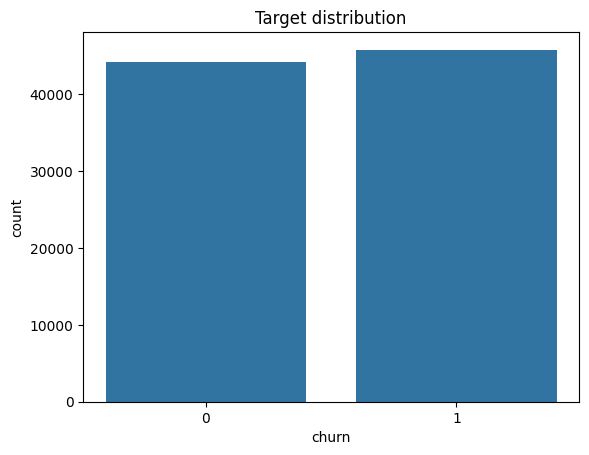

In [147]:
sns.countplot(data=df,x="churn")
plt.title('Target distribution')
plt.plot()
# el target esta bien balanceado

## Analisis Univariable

* Distribucion de cada variable

In [148]:
print('Valores unicos en columnas categoricas:')
unicos(df,"O") # unicos en columnas categoricas

Valores unicos en columnas categoricas:
new_cell ['U' 'N' 'Y'] 

crclscod ['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA' 'J' 'U' 'Z' 'K' 'E' 'E4' 'W'
 'DA' 'Y' 'CC' 'GA' 'D4' 'D5' 'H' 'ZA' 'JF' 'B2' 'IF' 'Z1' 'O' 'M' 'L'
 'U1' 'Z4' 'A2' 'V' 'TP' 'EM' 'C2' 'C5' 'S' 'EC' 'Z5' 'D2' 'GY' 'ZY' 'E2'
 'A3' 'V1' 'EF' 'Z2' 'CY' 'P1' 'ZF'] 

asl_flag ['N' 'Y'] 

prizm_social_one ['S' 'U' 'T' 'C' nan 'R'] 

area ['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'
 'NEW ENGLAND AREA' 'DALLAS AREA' 'CENTRAL/SOUTH TEXAS AREA'
 'TENNESSEE AREA' 'MIDWEST AREA' 'PHILADELPHIA AREA' 'OHIO AREA'
 'HOUSTON AREA' 'SOUTHWEST AREA' 'NEW YORK CITY AREA'
 'ATLANTIC SOUTH AREA' 'SOUTH FLORIDA AREA' 'CALIFORNIA NORTH AREA'
 'DC/MARYLAND/VIRGINIA AREA' 'NORTH FLORIDA AREA' nan 'LOS ANGELES AREA'] 

dualband ['Y' 'N' 'T' 'U' nan] 

refurb_new ['N' 'R' nan] 

hnd_webcap ['WCMB' 'WC' nan 'UNKW'] 

ownrent ['O' nan 'R'] 

dwlltype ['S' 'M' nan] 

marital ['S' 'M' 'A' 'U' 'B' nan] 

infobase ['M' nan] 

HH

In [149]:
#Value counts
# Observaciones:
# columna hnd_price se puede redondear para pasar a int
# columna asl_flag  se puede puede transformar a binaria
valcounts(df,100)

drop_dat 
 0.000000      87782
0.333333        965
0.666667        438
1.000000        193
1.333333        146
1.666667         86
2.000000         64
2.333333         42
2.666667         36
3.333333         27
3.000000         27
4.000000         24
3.666667         19
4.333333         16
5.000000         14
5.333333         10
5.666667         10
6.000000          9
4.666667          9
9.333333          7
6.333333          7
7.333333          6
8.000000          5
8.333333          5
6.666667          5
10.000000         4
7.000000          4
9.666667          3
10.666667         3
11.000000         2
18.666667         2
12.000000         2
13.000000         2
9.000000          2
15.333333         1
15.000000         1
11.333333         1
8.666667          1
7.666667          1
20.666667         1
33.666667         1
14.000000         1
18.000000         1
20.000000         1
20.333333         1
25.333333         1
16.333333         1
21.333333         1
47.333333         1
12.333333

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


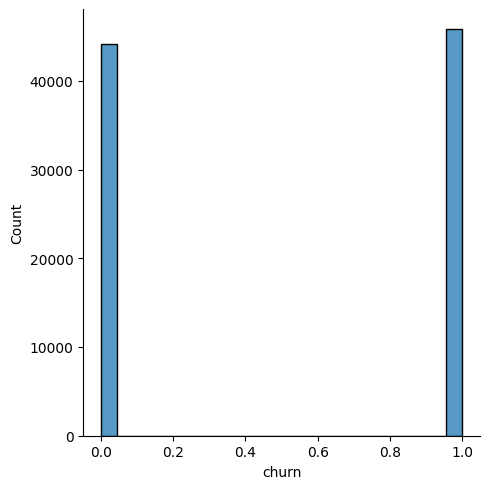

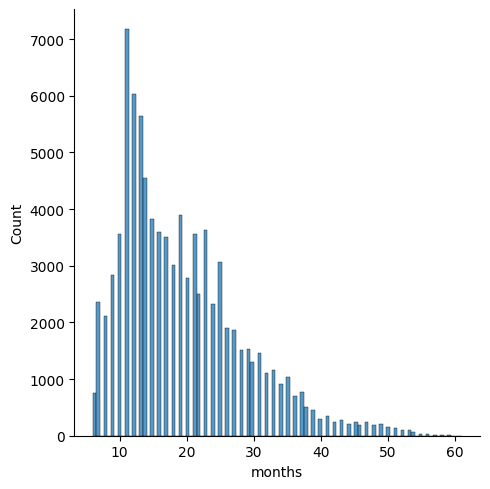

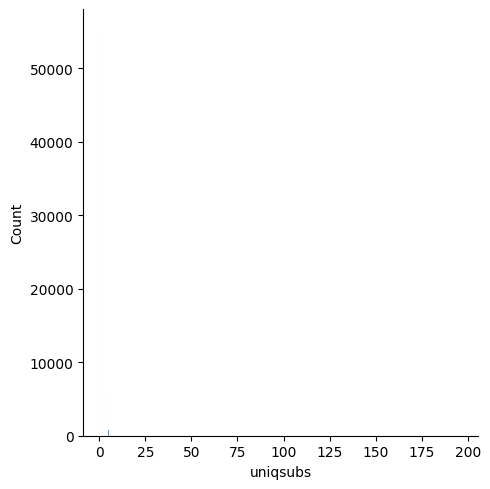

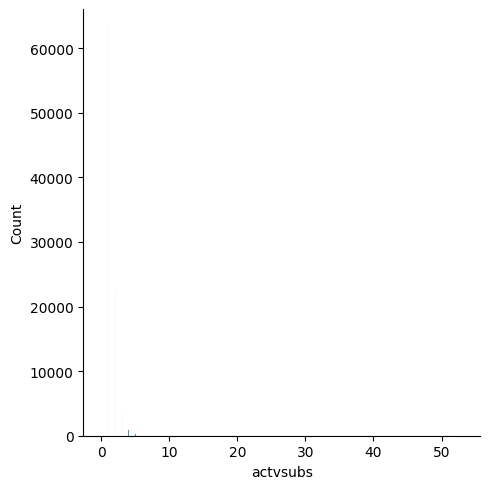

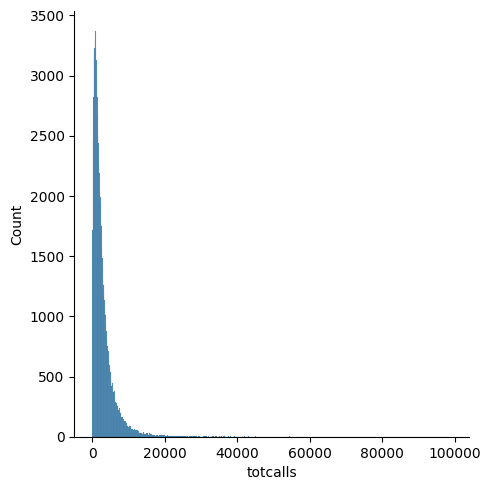

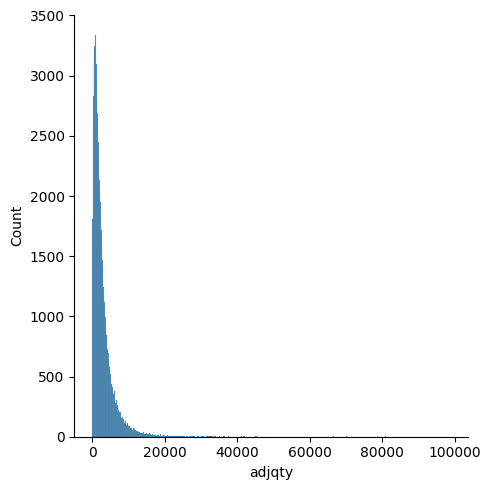

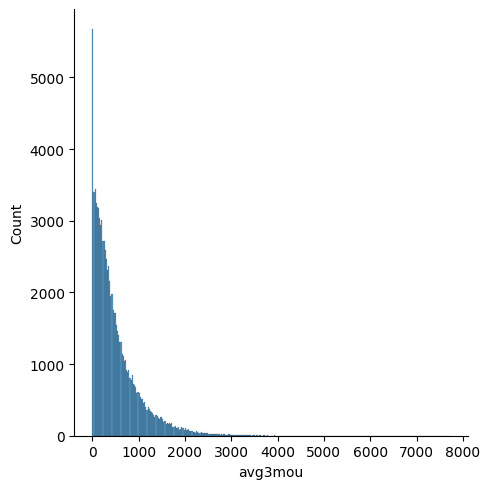

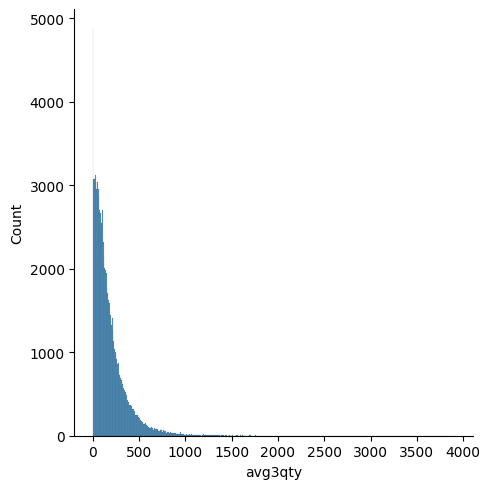

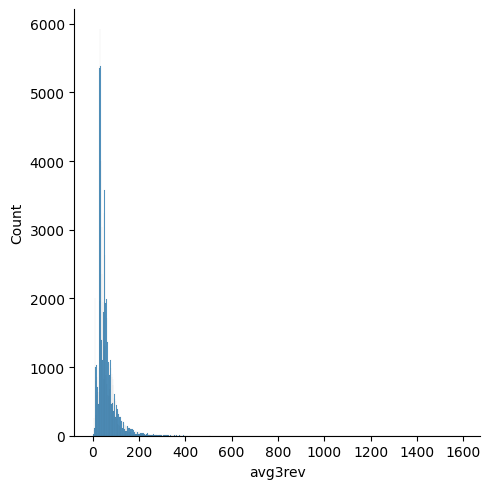

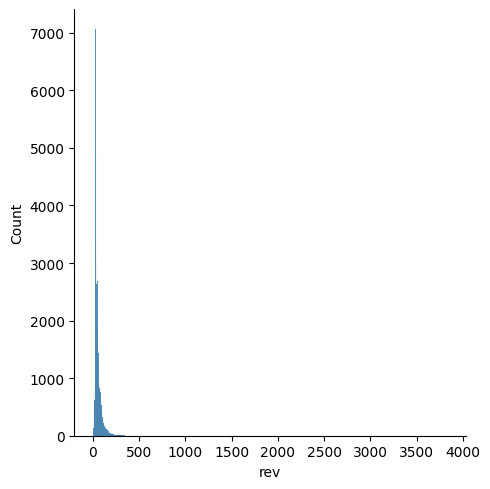

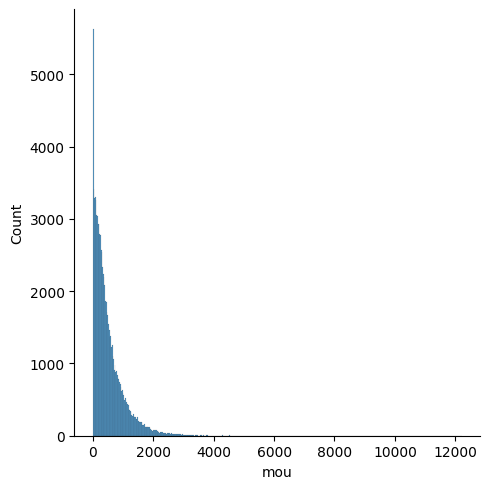

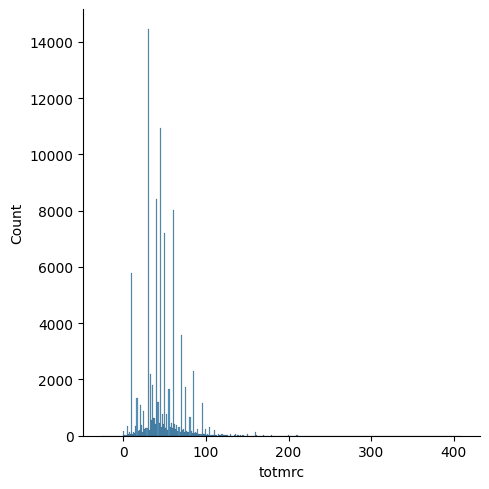

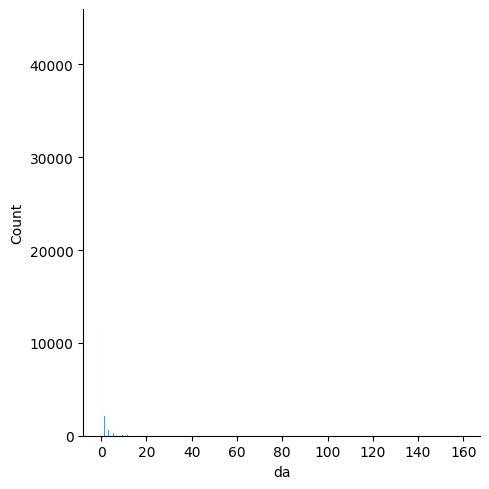

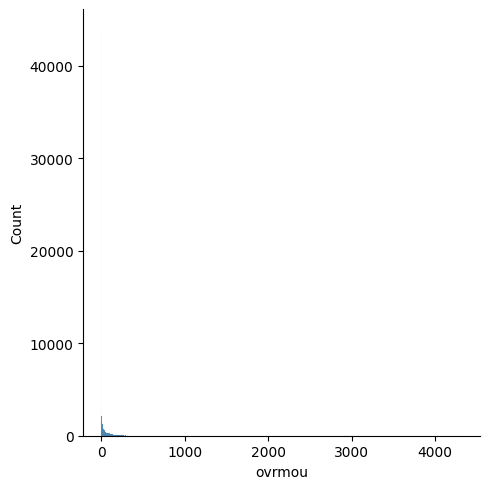

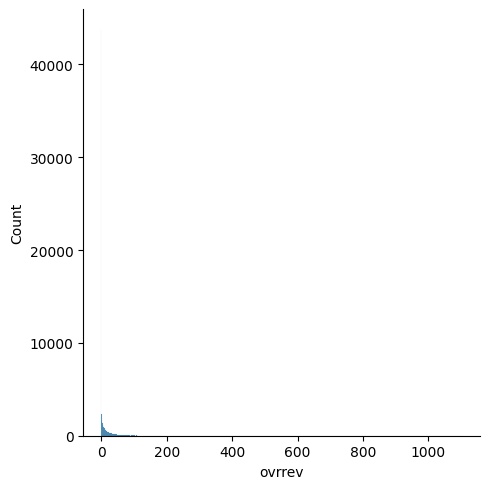

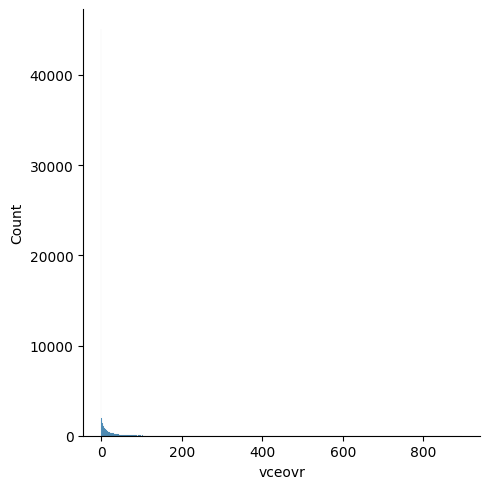

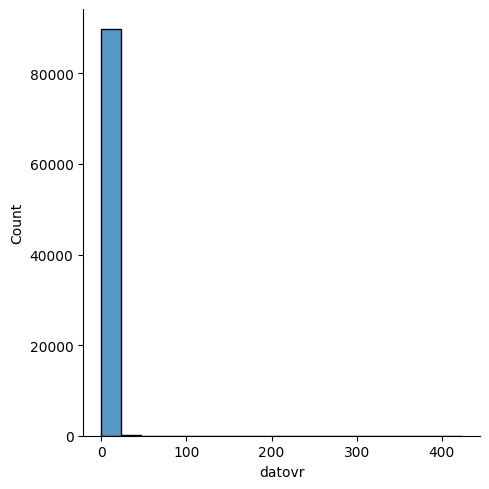

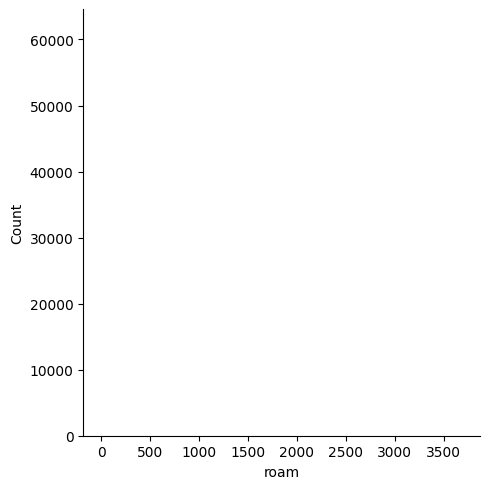

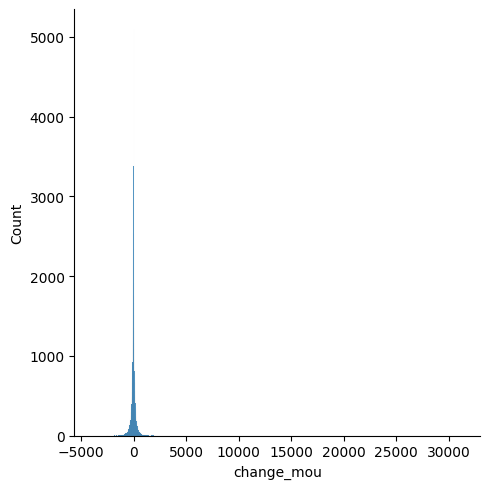

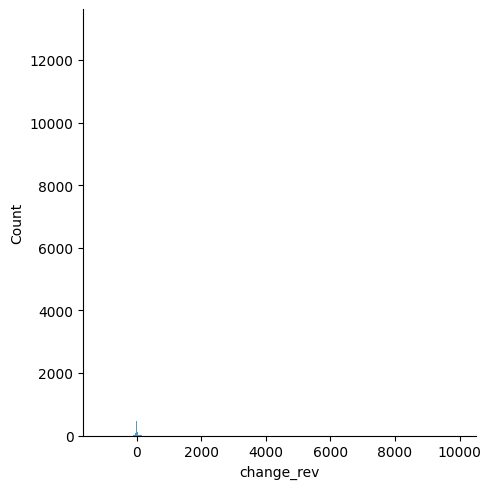

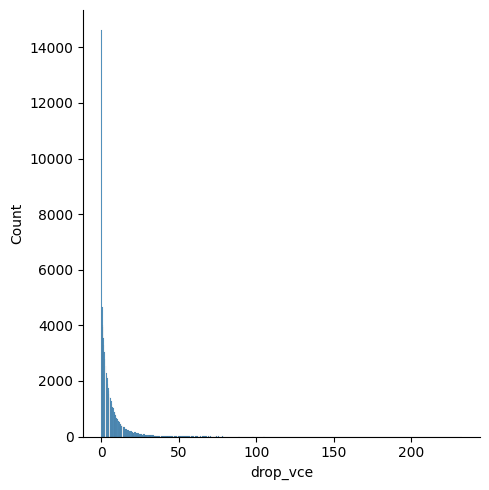

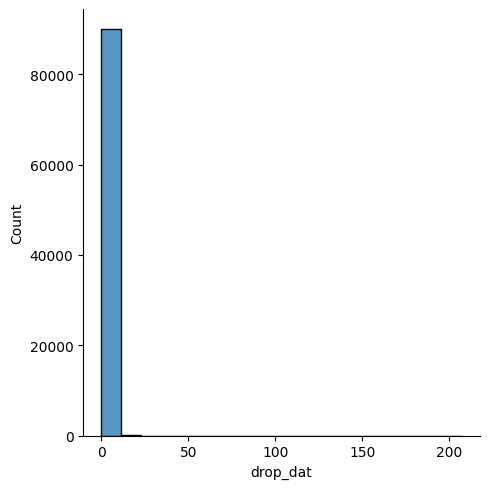

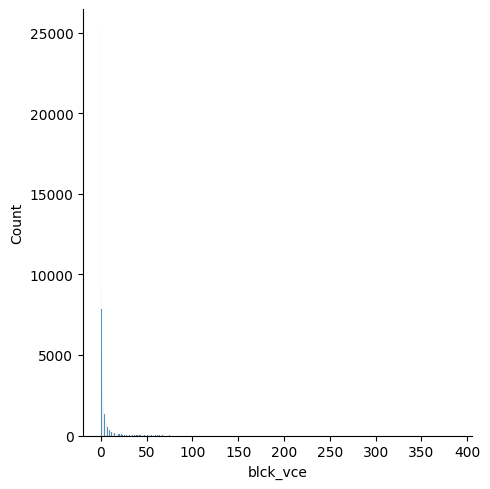

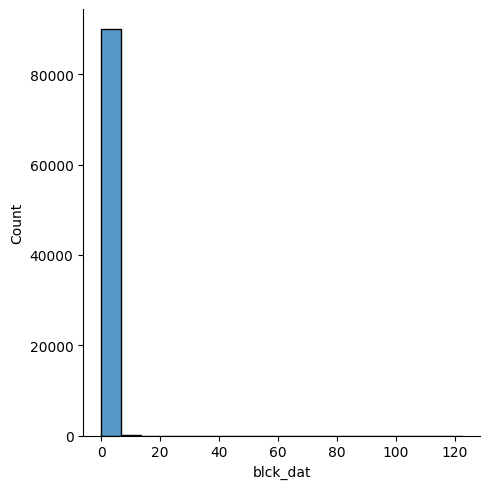

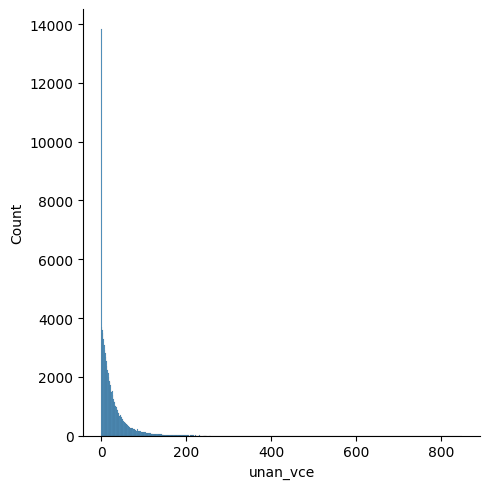

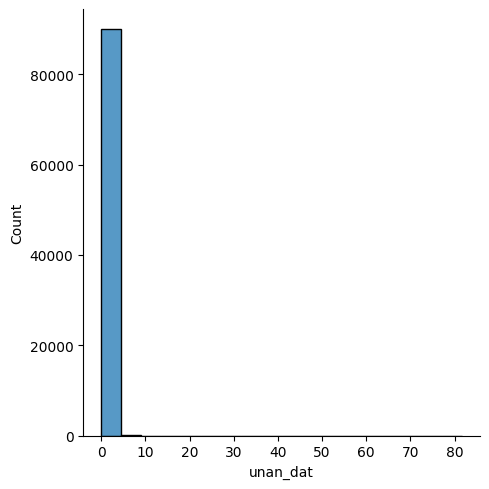

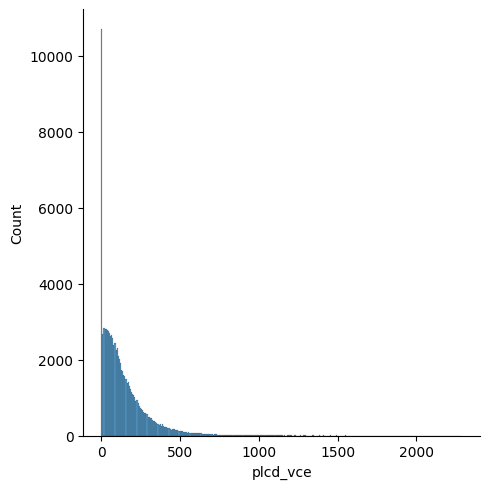

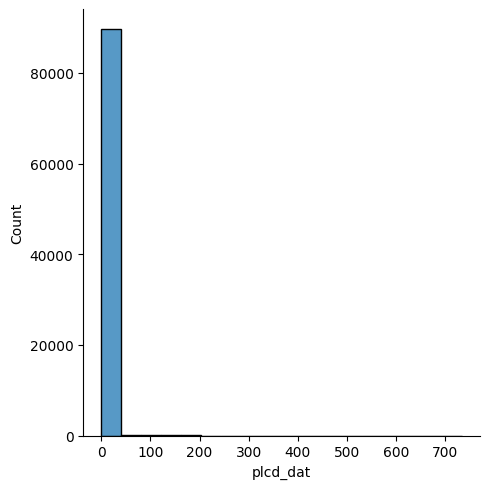

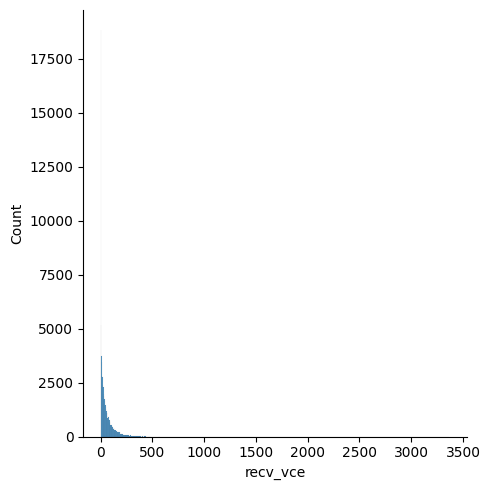

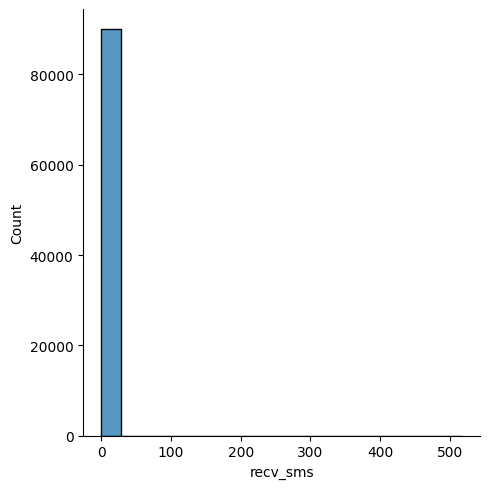

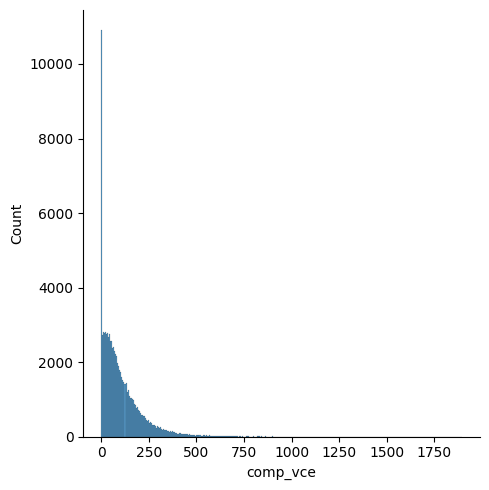

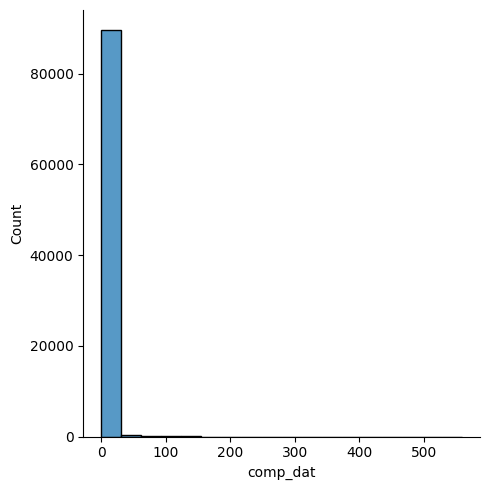

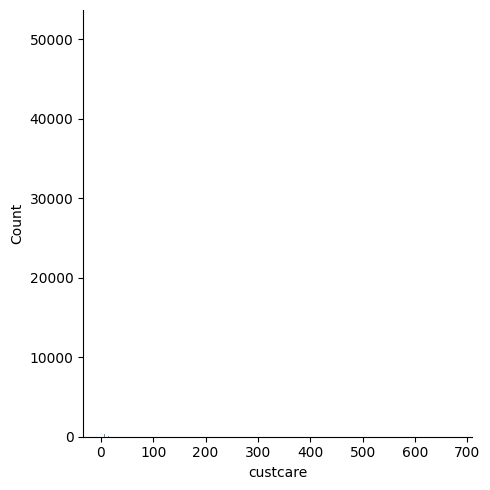

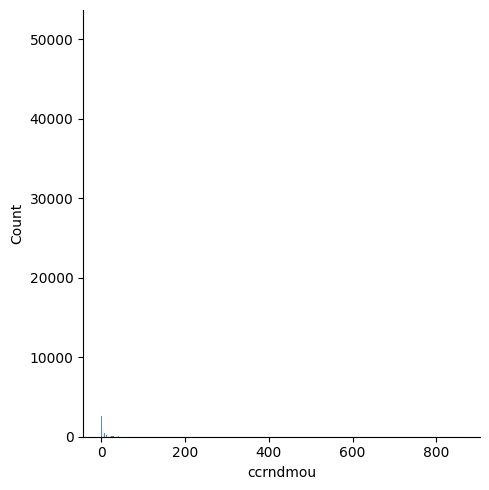

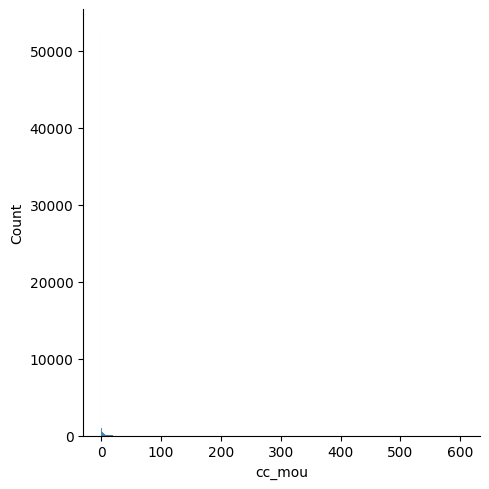

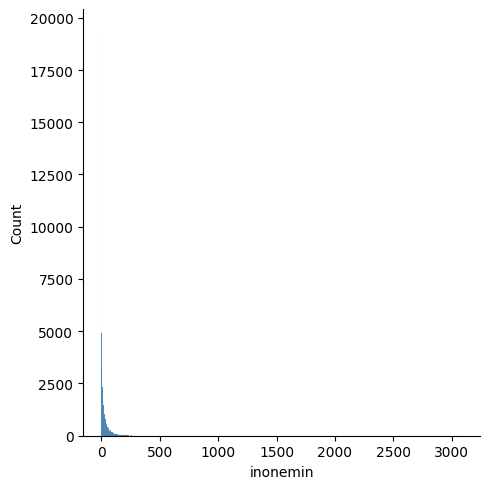

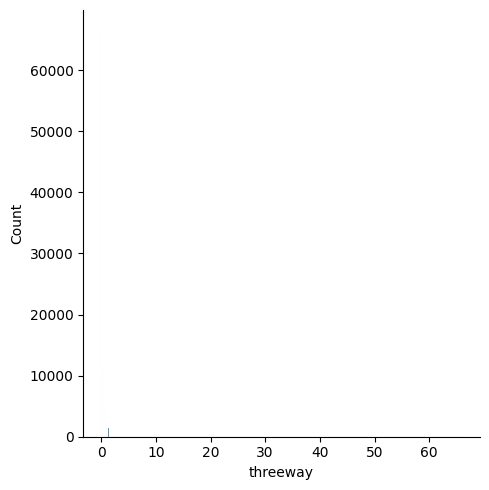

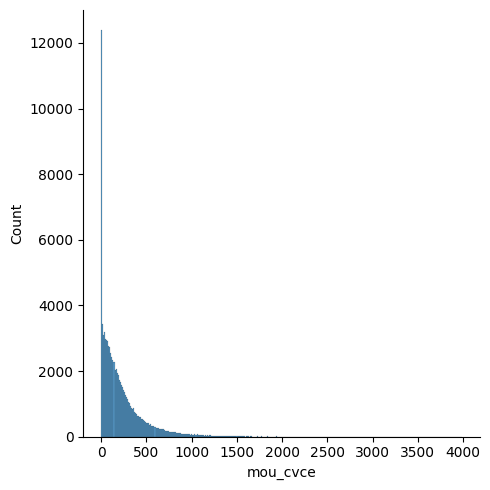

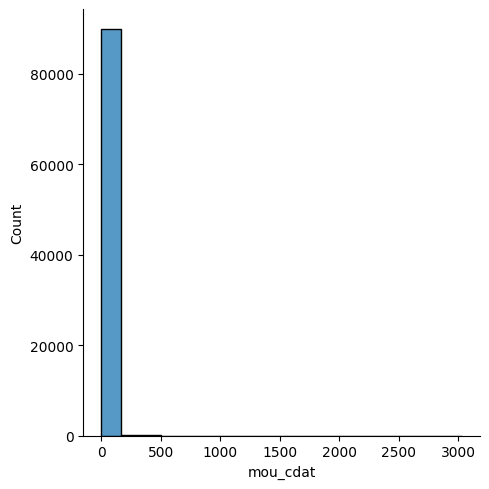

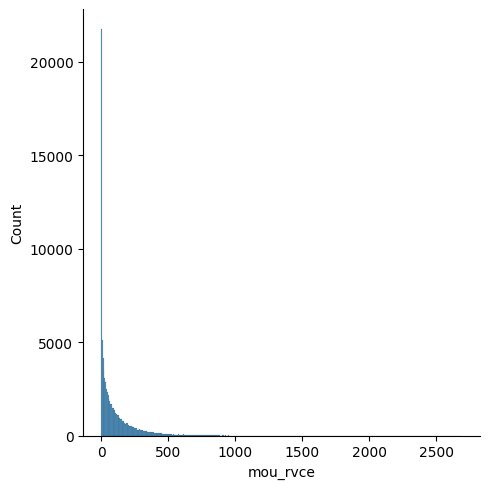

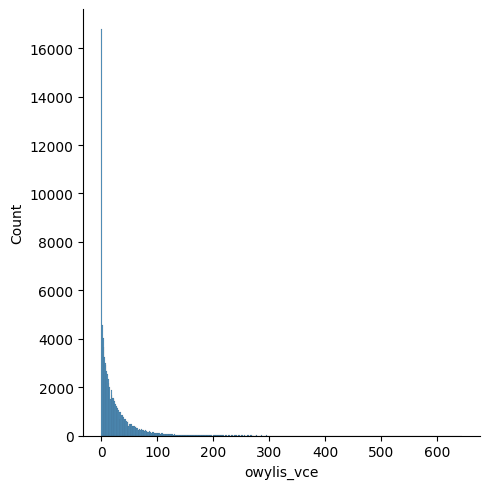

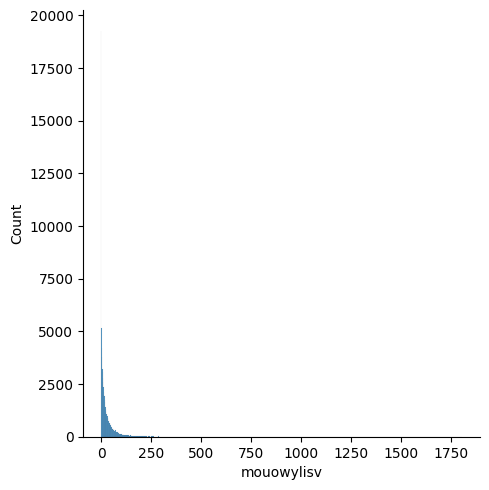

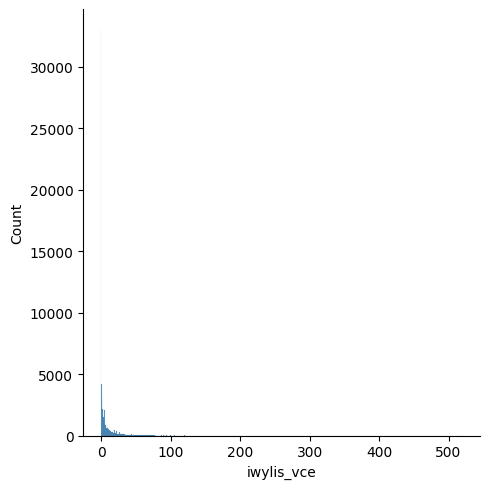

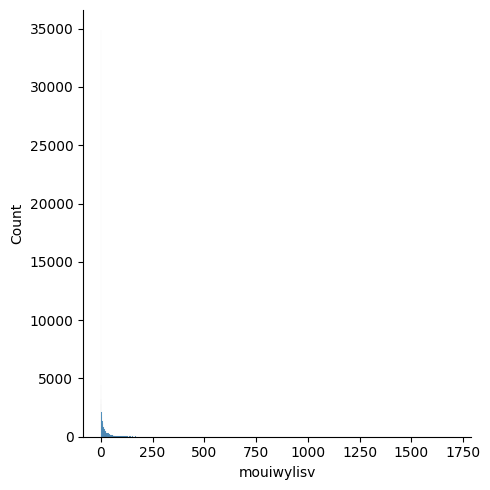

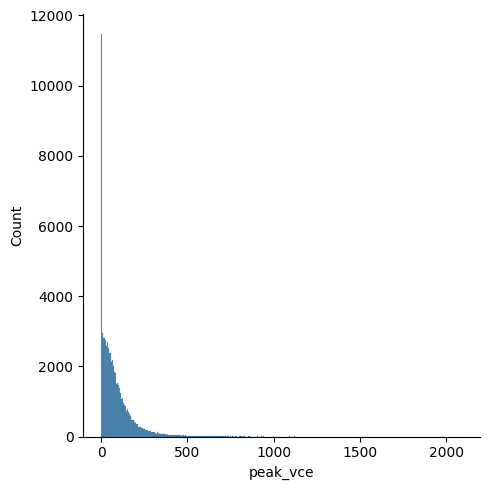

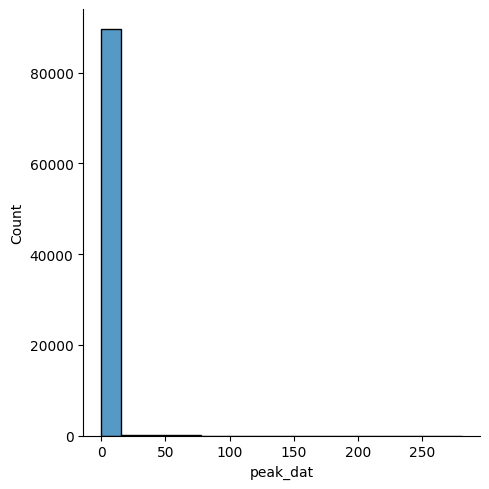

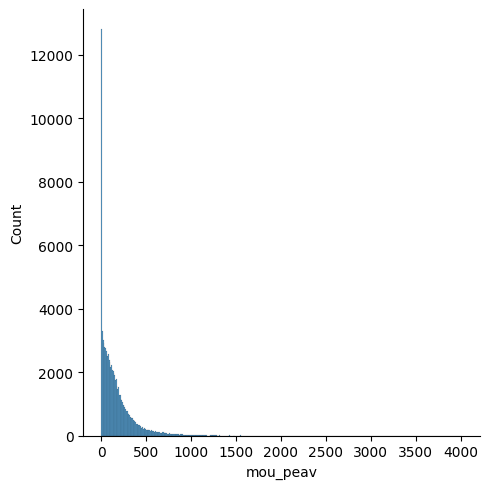

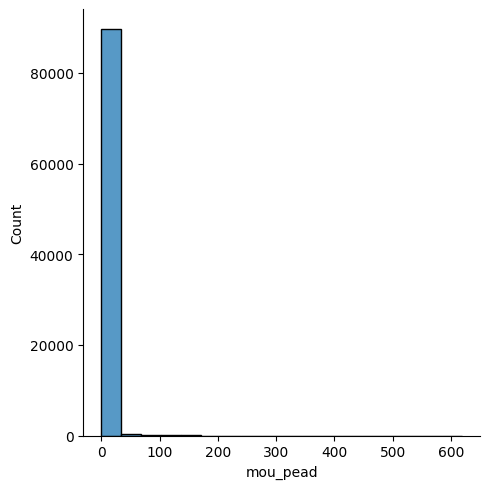

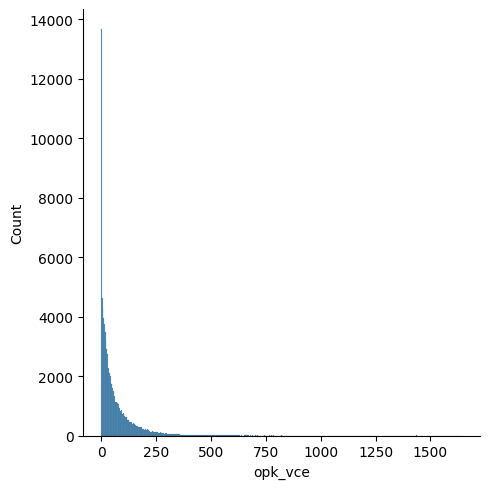

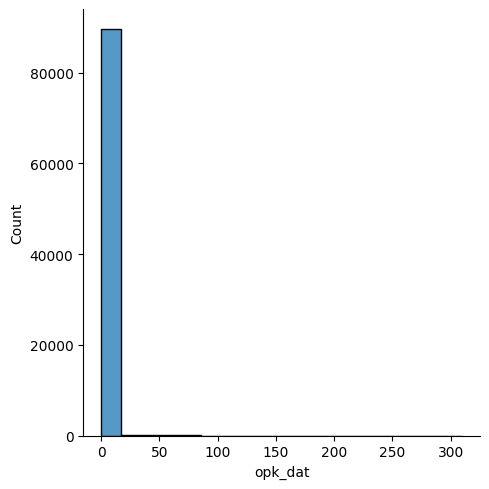

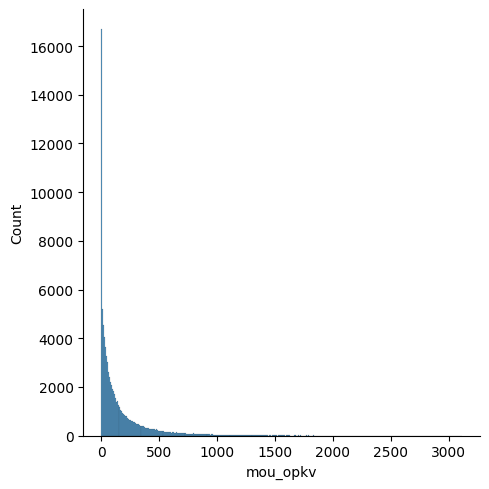

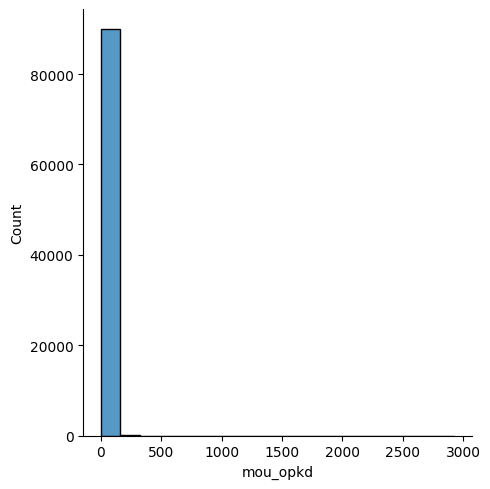

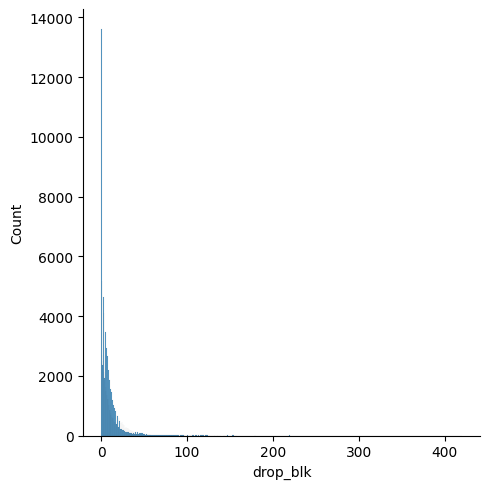

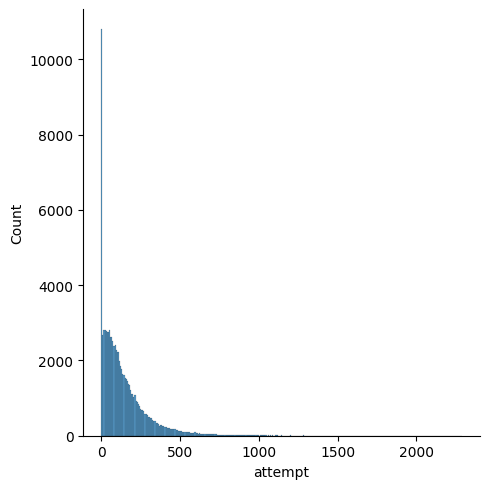

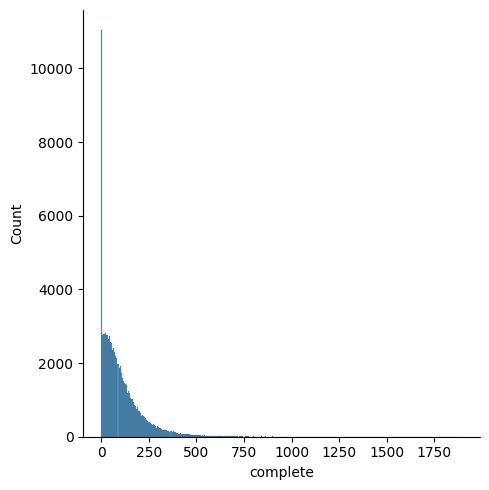

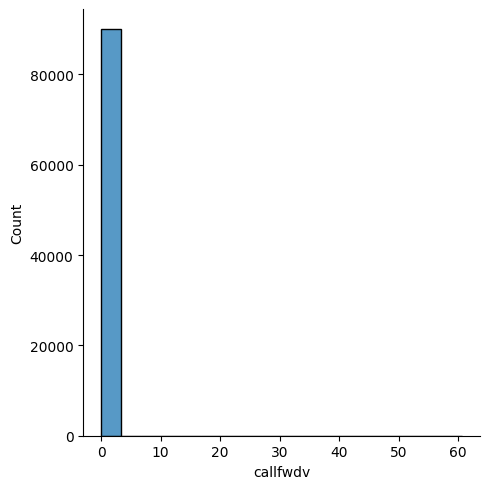

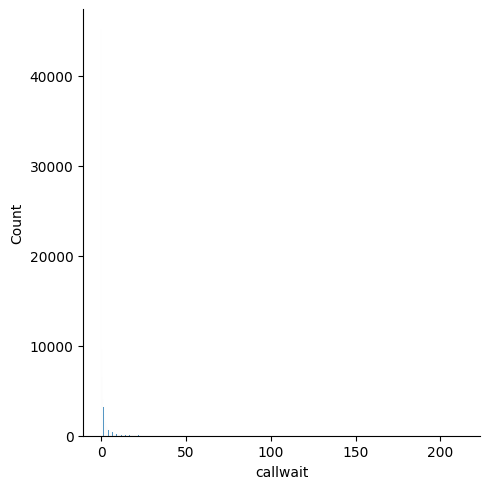

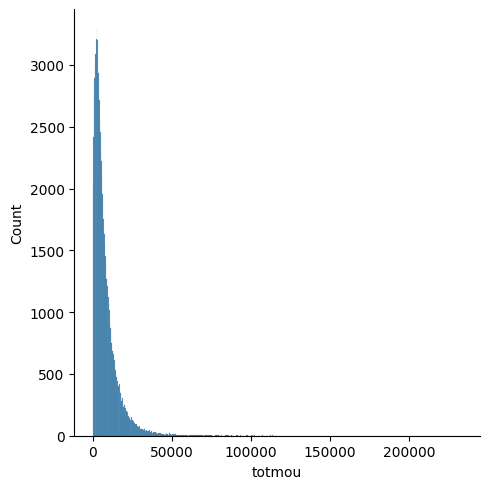

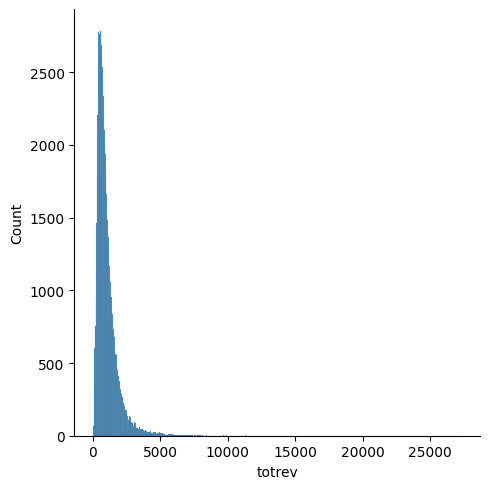

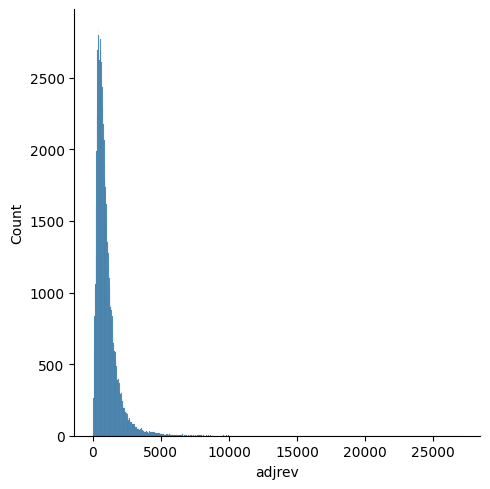

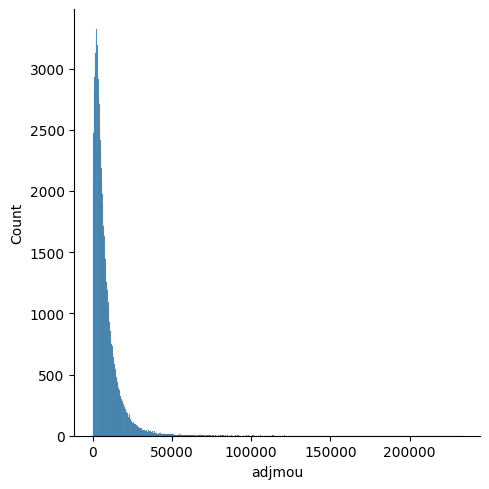

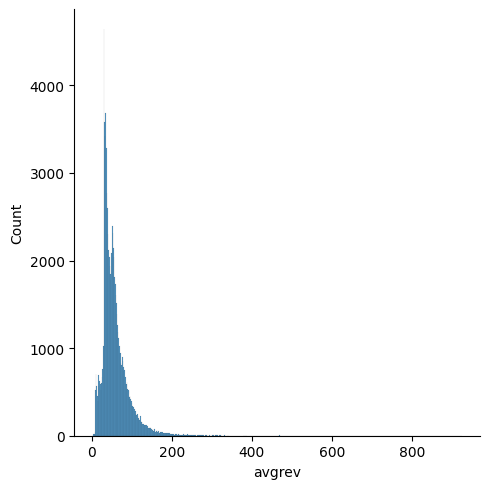

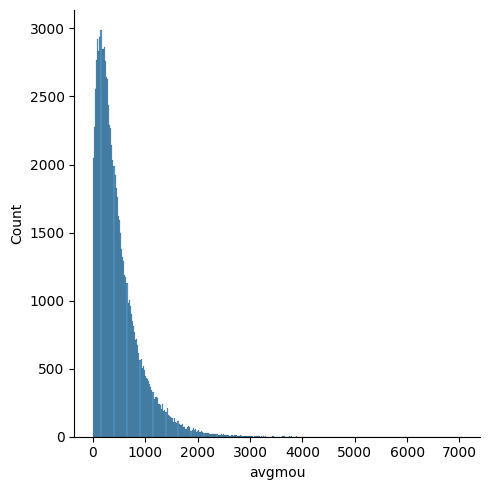

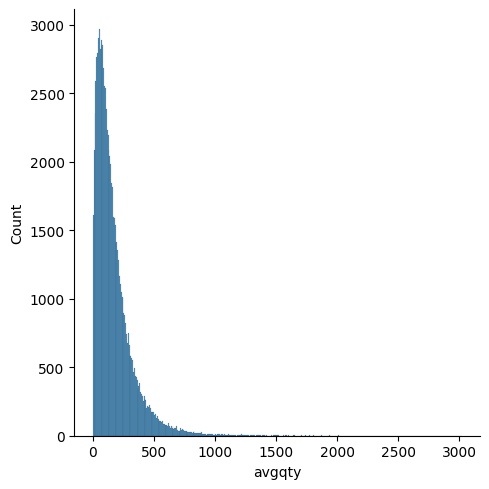

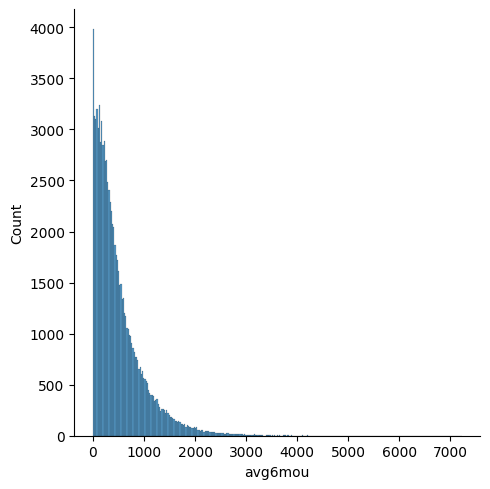

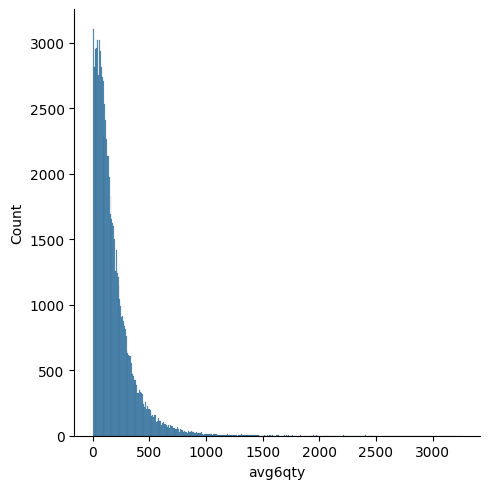

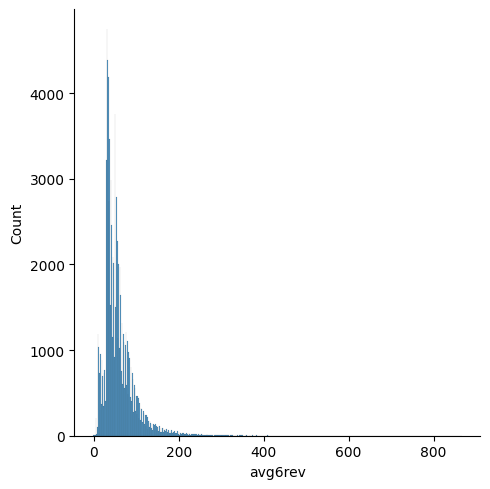

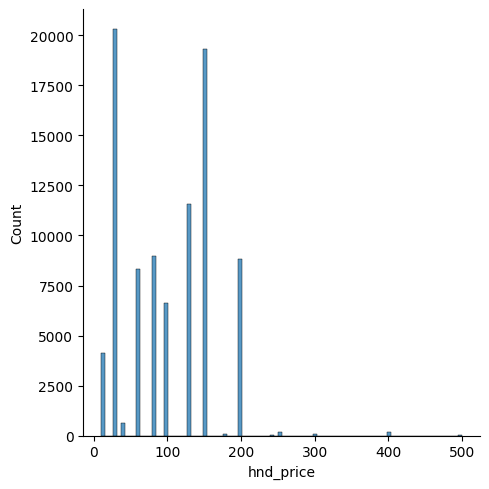

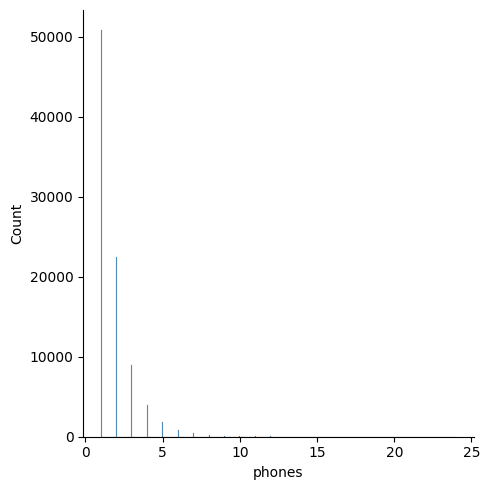

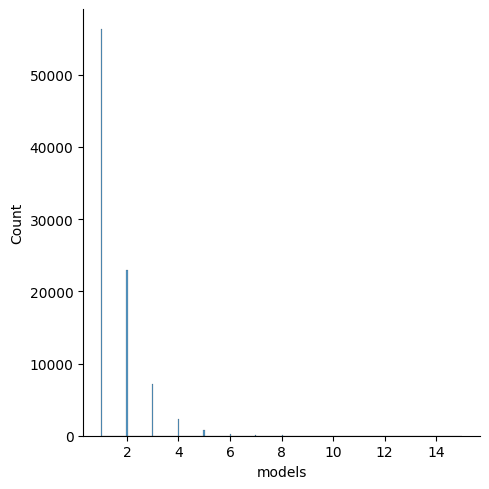

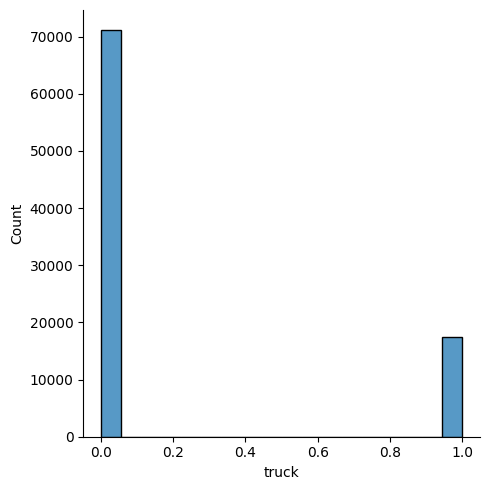

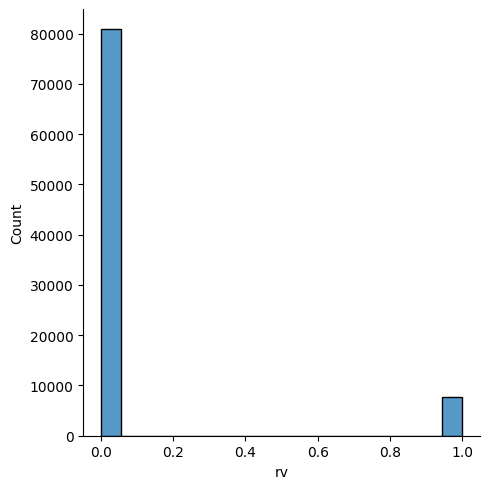

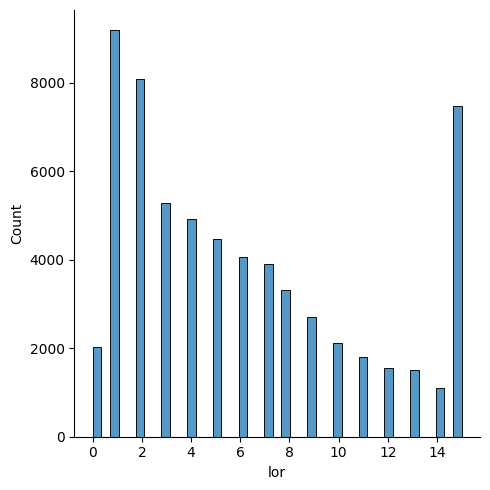

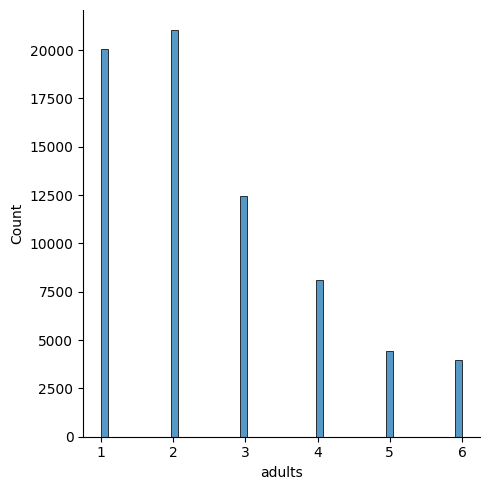

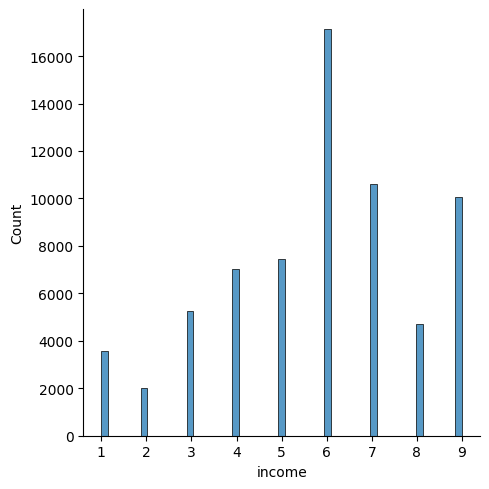

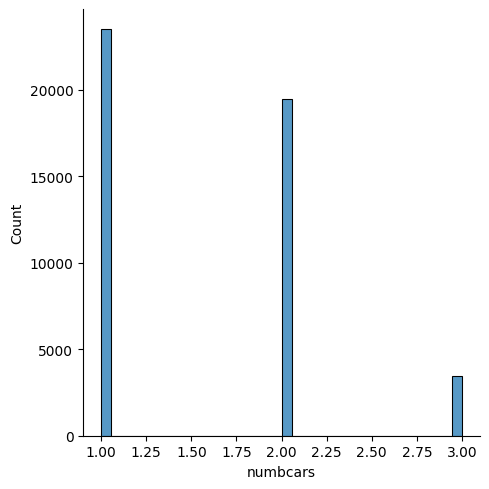

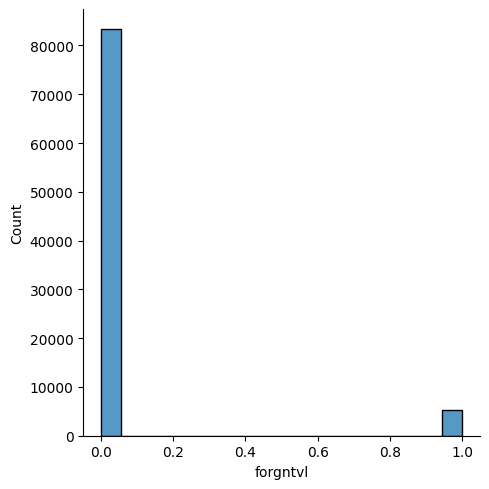

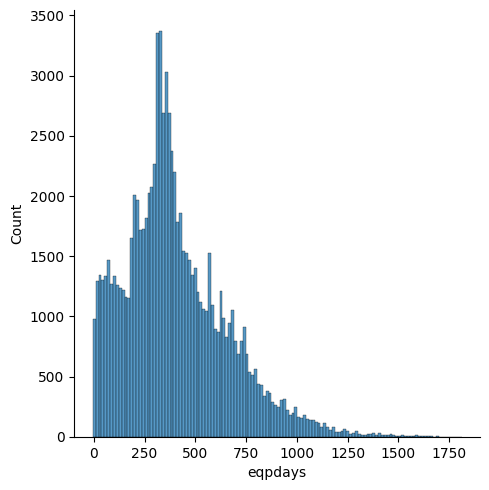

In [150]:
hist(df) # Generamos histogramas de columnas numericas.

In [151]:
# forgntvl,truck, rv tienen comportamiento booleano, se  reemplazaran 1 por Verdadero y 0 por Falso, para que luego los nulos sean tratados como desconocidos.
print('Se remplazan los 1 por Verdadero y los 0 por Falso para las columnas: forgntvl,truck, rv')
for i in ["forgntvl","truck","rv"]:
    print(df[i].dtype.kind)
    print(df[i].value_counts(dropna=False))

Se remplazan los 1 por Verdadero y los 0 por Falso para las columnas: forgntvl,truck, rv
f
0.0    83302
1.0     5247
NaN     1451
Name: forgntvl, dtype: int64
f
0.0    71088
1.0    17461
NaN     1451
Name: truck, dtype: int64
f
0.0    80857
1.0     7692
NaN     1451
Name: rv, dtype: int64


In [152]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
rev,89866.0,58.312895,46.084103,-5.862500,33.027500,47.667500,70.193750,3843.262500
mou,89866.0,504.277946,516.170057,0.000000,148.500000,349.000000,689.000000,12206.750000
totmrc,89866.0,45.880669,23.370435,-26.915000,30.000000,44.990000,59.990000,409.990000
da,89866.0,0.877813,2.173665,0.000000,0.000000,0.247500,0.742500,159.390000
ovrmou,89866.0,40.798976,96.970619,0.000000,0.000000,2.500000,41.250000,4320.750000
ovrrev,89866.0,13.289932,30.123282,0.000000,0.000000,0.900000,13.912500,1102.400000
vceovr,89866.0,13.046046,29.719581,0.000000,0.000000,0.600000,13.562500,896.087500
datovr,89866.0,0.240786,3.012631,0.000000,0.000000,0.000000,0.000000,423.540000
roam,89866.0,1.308197,15.374215,0.000000,0.000000,0.000000,0.257500,3685.200000
change_mou,89405.0,-13.786987,271.624916,-3875.000000,-85.750000,-6.500000,61.250000,31219.250000


## Analisis Variable-Target

* Relacion target-variable

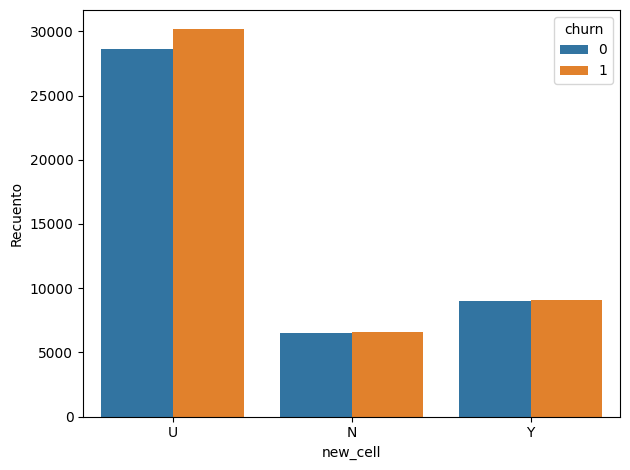

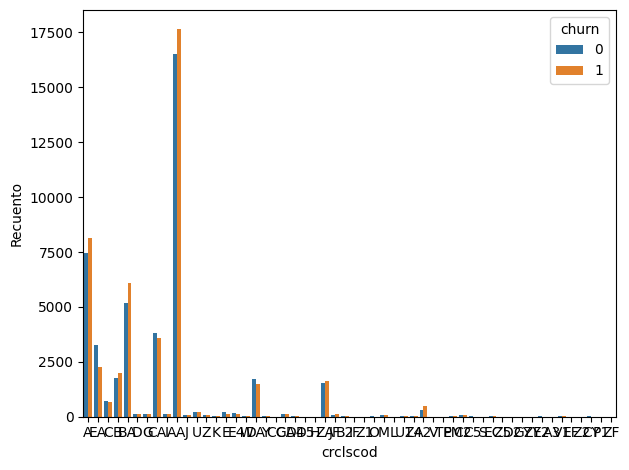

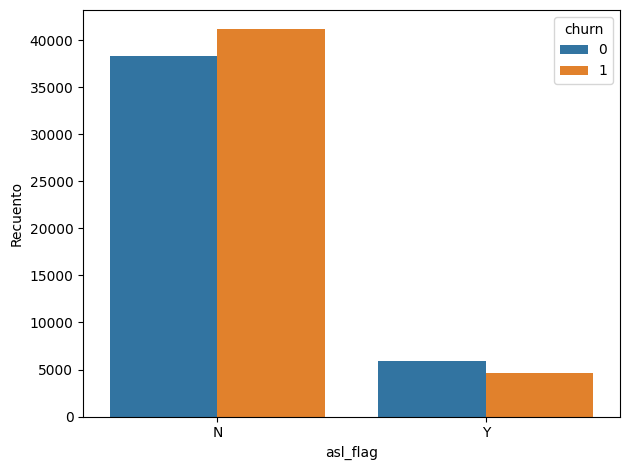

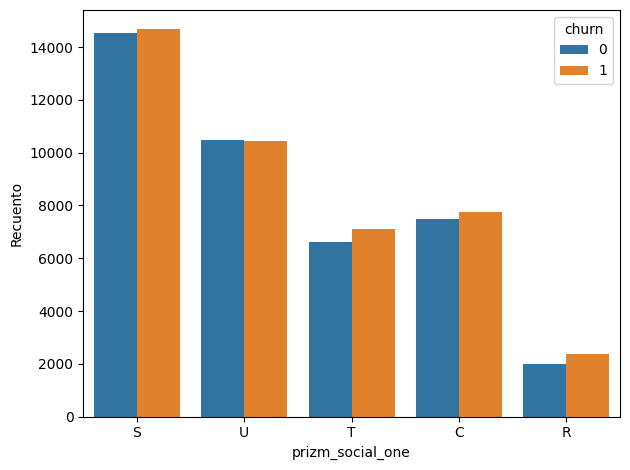

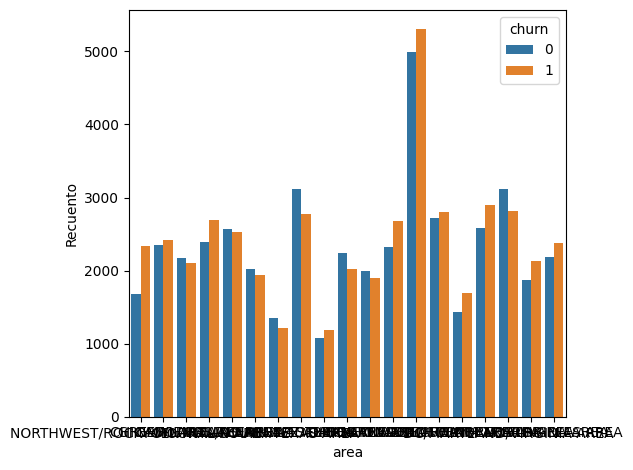

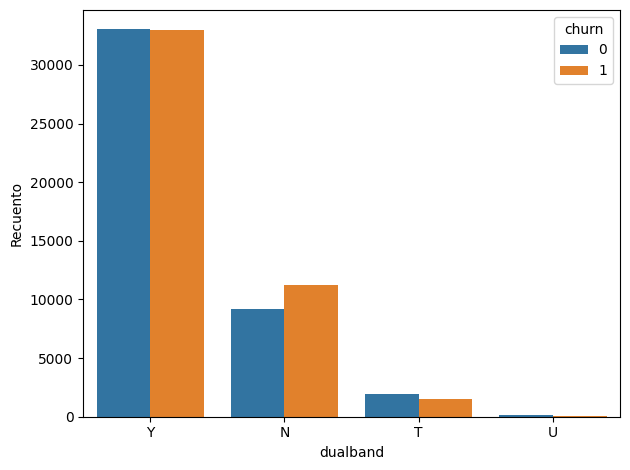

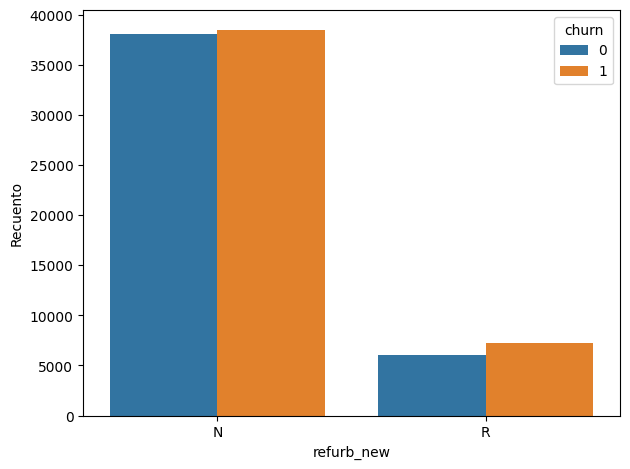

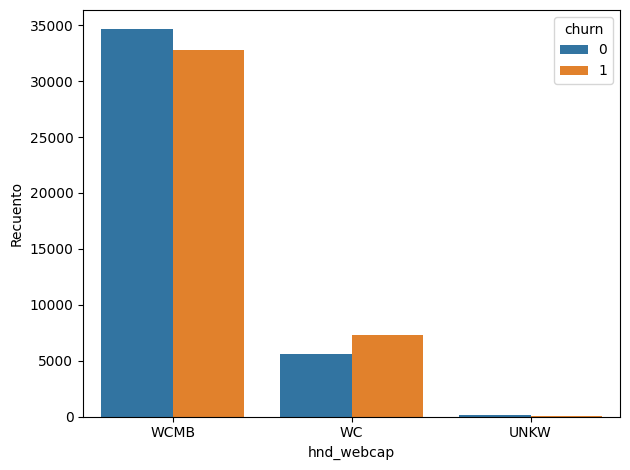

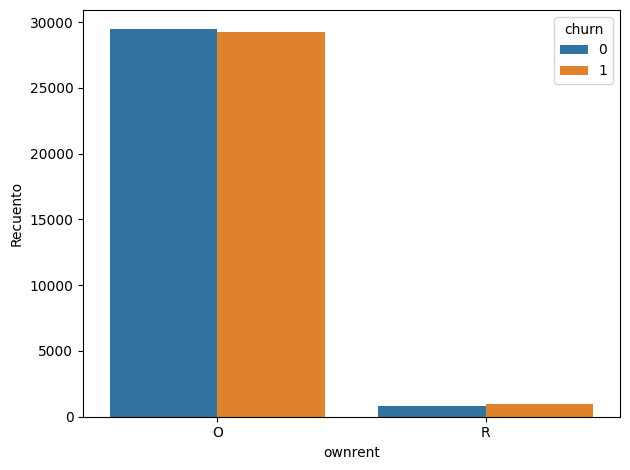

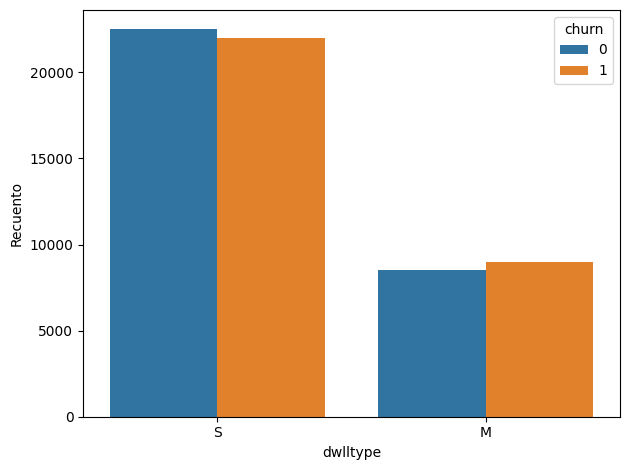

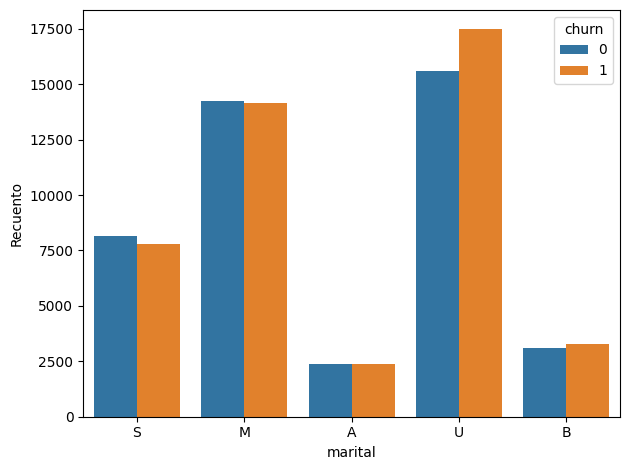

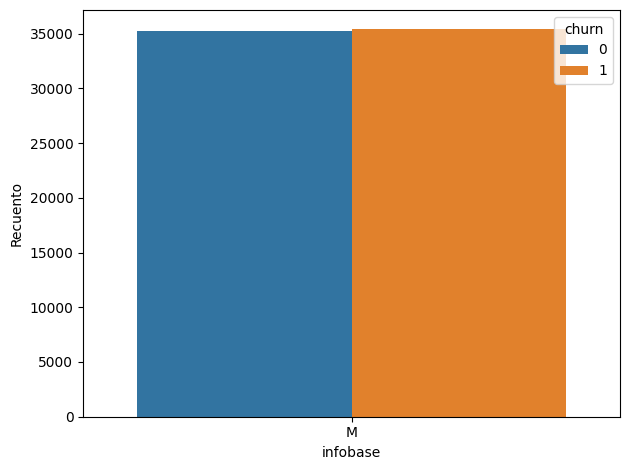

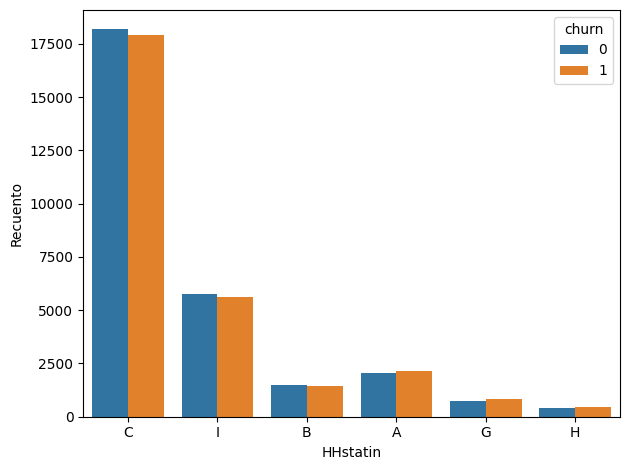

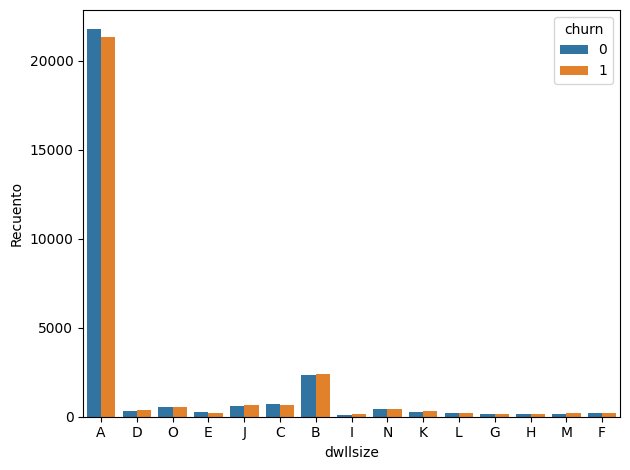

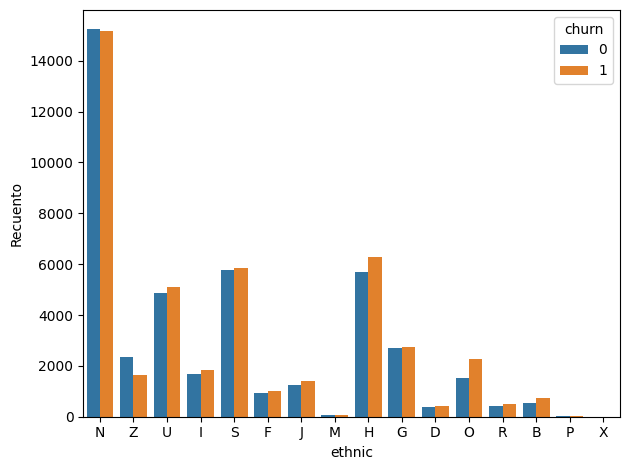

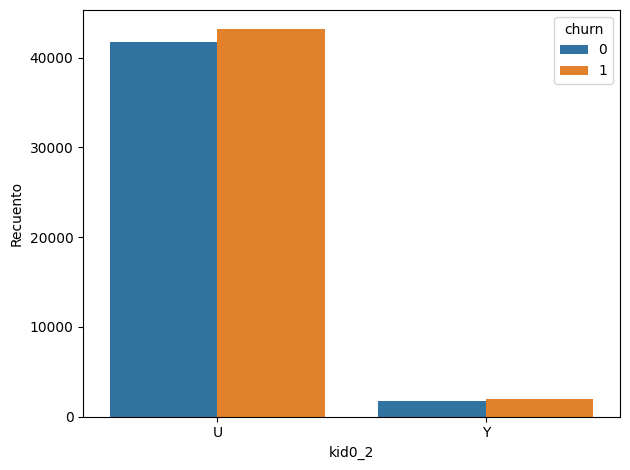

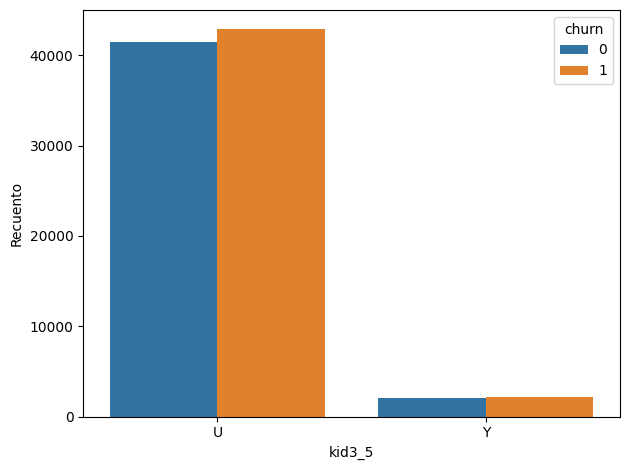

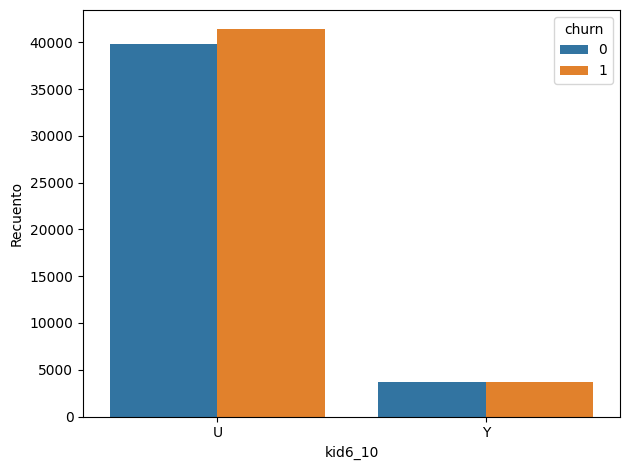

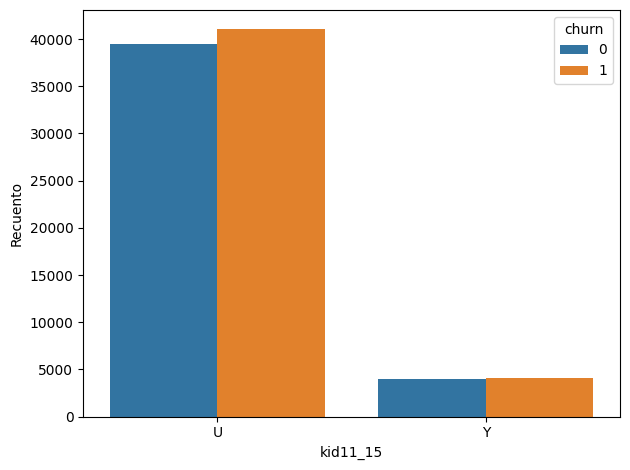

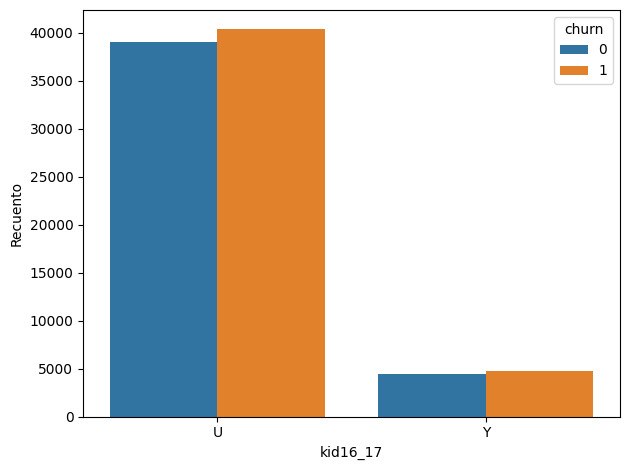

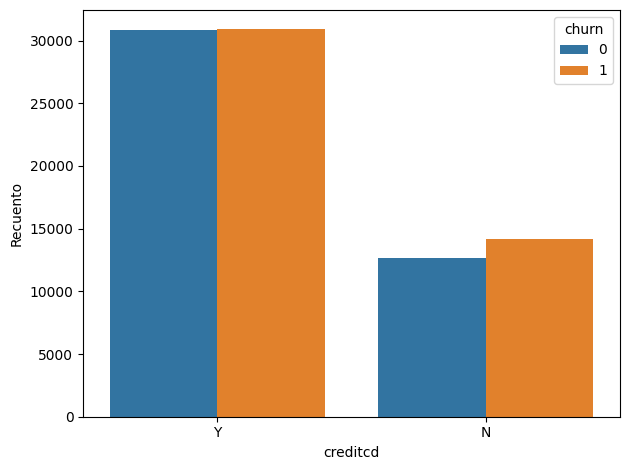

In [156]:
for i in df.select_dtypes(exclude = np.number).columns.tolist():
      sns.countplot(x=i,hue="churn", data=df)
      plt.ylabel('Recuento')
      plt.tight_layout()  # Ajustar diseño para evitar superposiciones
      plt.show()

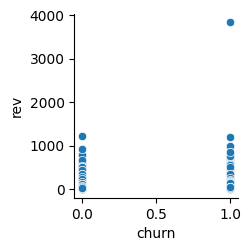

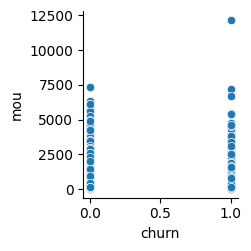

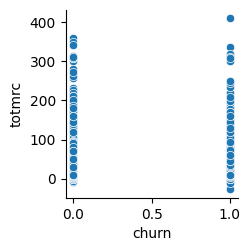

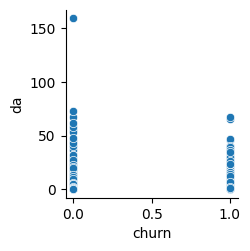

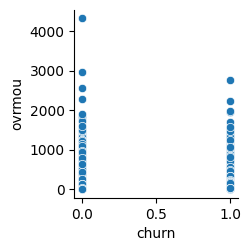

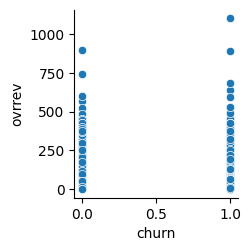

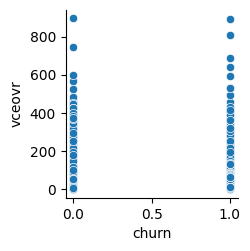

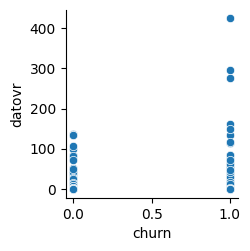

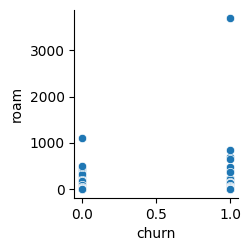

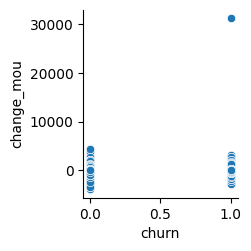

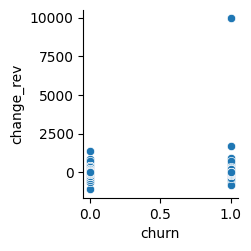

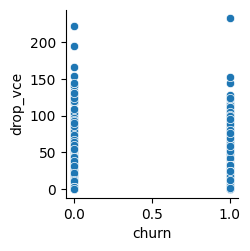

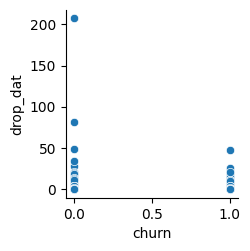

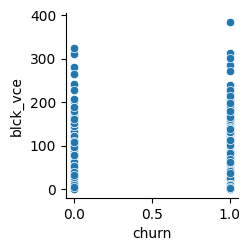

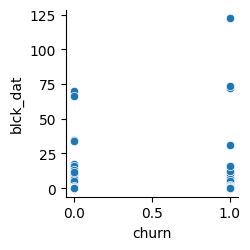

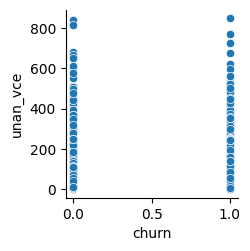

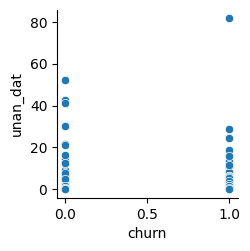

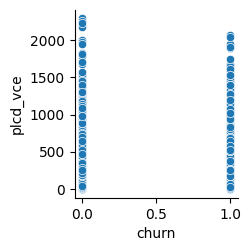

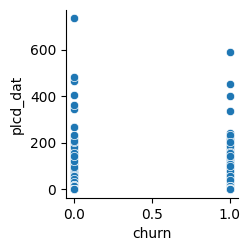

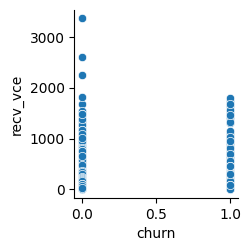

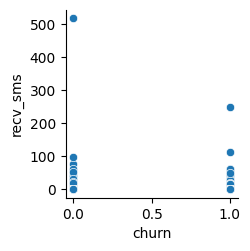

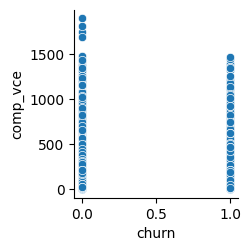

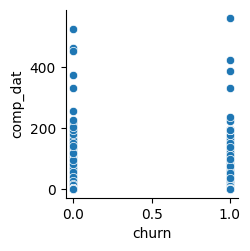

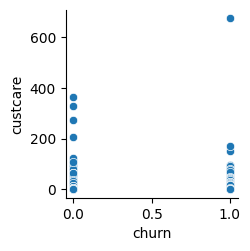

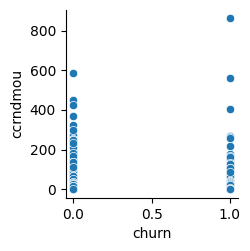

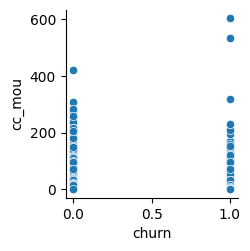

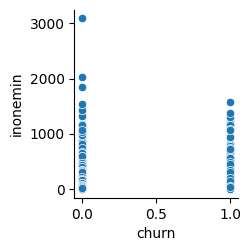

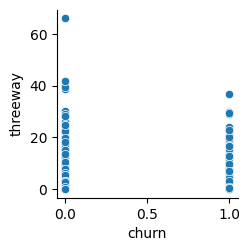

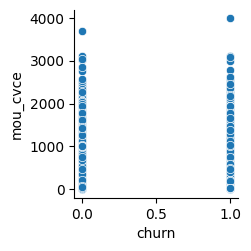

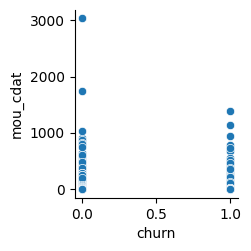

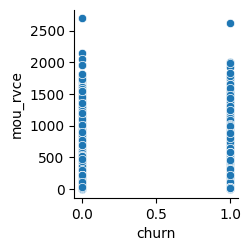

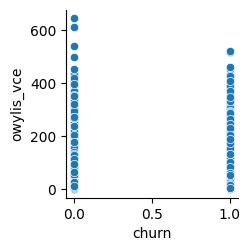

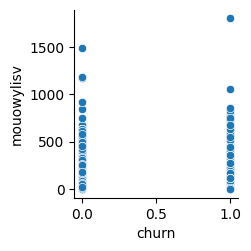

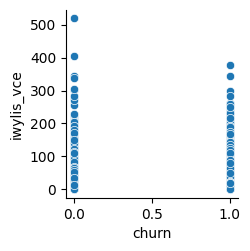

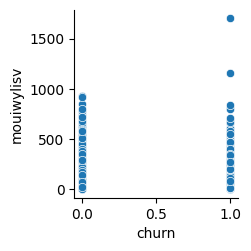

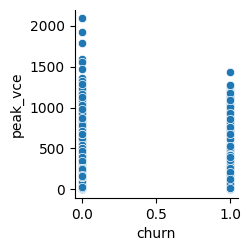

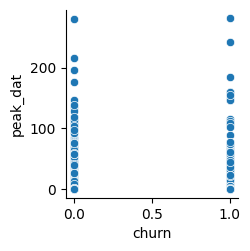

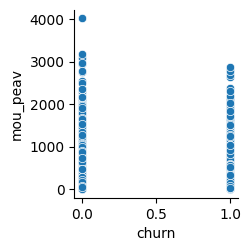

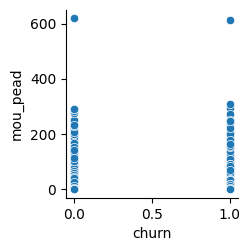

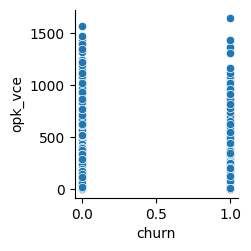

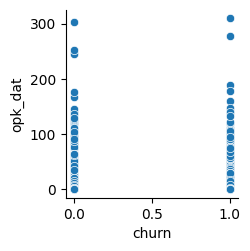

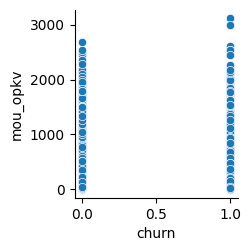

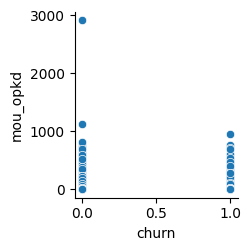

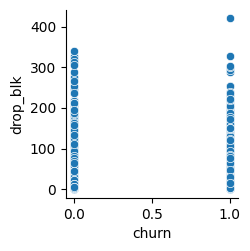

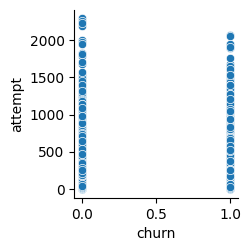

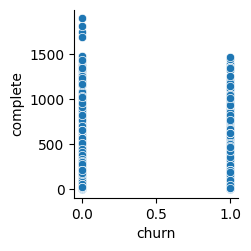

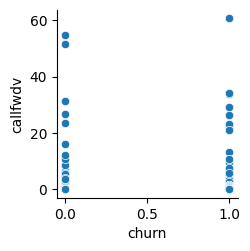

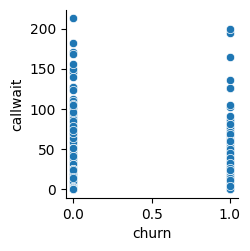

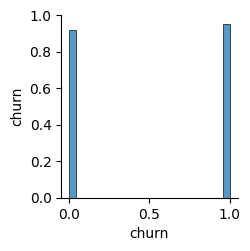

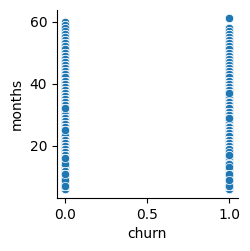

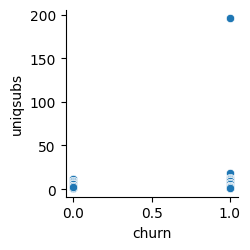

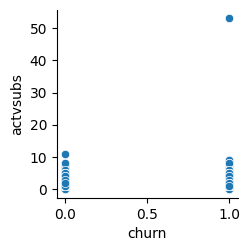

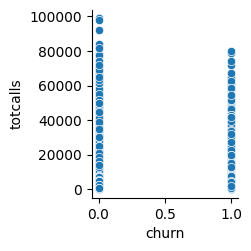

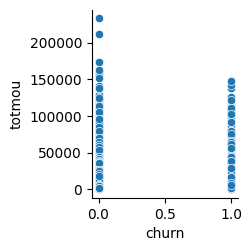

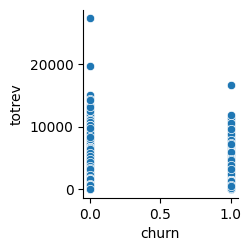

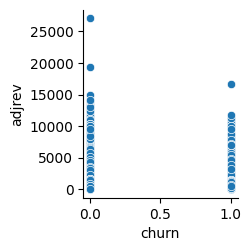

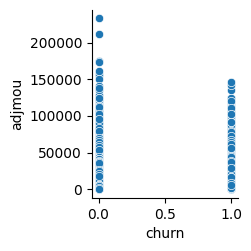

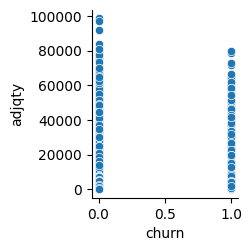

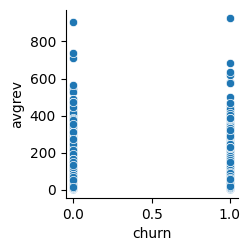

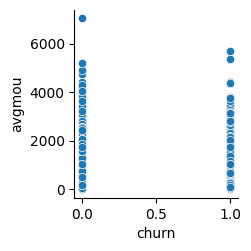

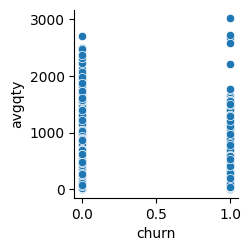

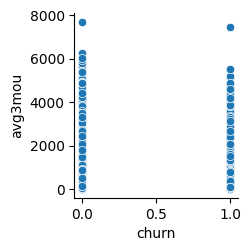

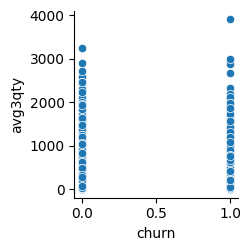

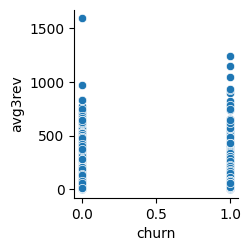

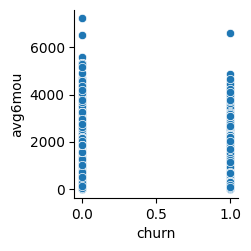

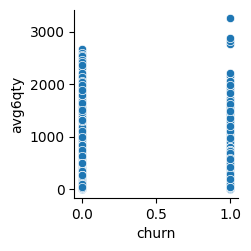

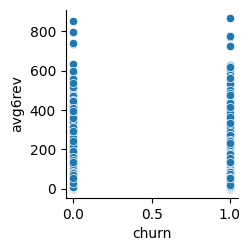

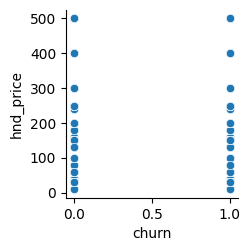

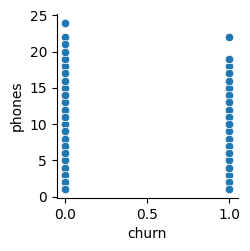

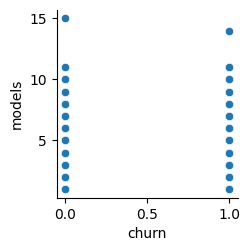

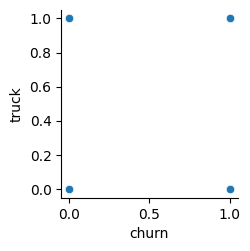

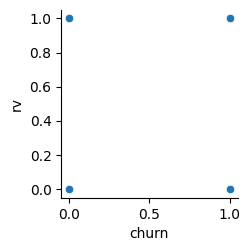

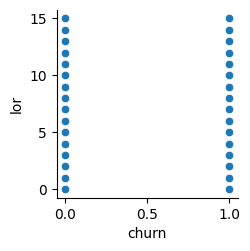

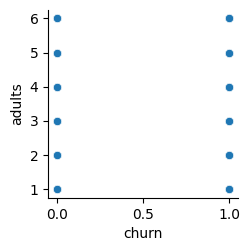

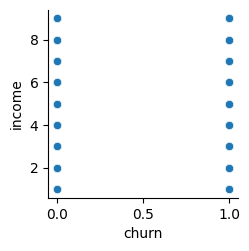

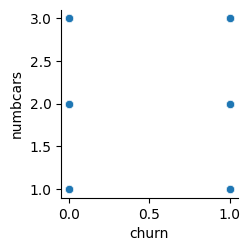

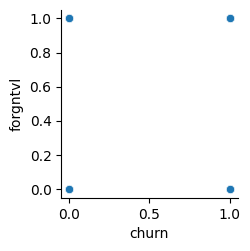

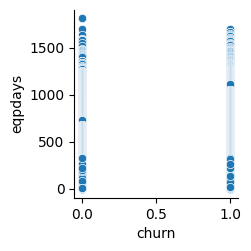

In [157]:
for i in df.select_dtypes(include = np.number).columns.tolist():
    sns.pairplot(df,x_vars="churn", y_vars=i)
    plt.show()

# Data Cleaning

* Eliminar filas sin target informado.
* Eliminar filas duplicadas (si tenemos ID, solo puede haber 1 registro por ID)
* Eliminar filas/columnas vacías y columnas irrelevantes
* Corregir data types incorrectos
* Categoricos: Corregir literales incorrectos (acentos, erratas, etc)
* Fechas y textos: convertir a variables numericas (hour, day, month, year...) o categoricas (weekday_name...)

In [158]:
print('Cantidad de nulos en la columna target: ')
df["churn"].isnull().sum() #validamos nulos en el target

Cantidad de nulos en la columna target: 


0

In [159]:
print('Revisamos existencia de filas duplicadas: ')
df[df.duplicated(keep=False)] #revisamos existencia de filas duplicadas

Revisamos existencia de filas duplicadas: 


,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [160]:
# Columnas menos relevantes
#newcell: demasiadas observaciones "U"(nulas)
#prizm_social_one: variable categorica con gran cantidad de nulos y "U"(desconococidas)
#area: variable categorica de alta cardinalidad cuya informacion no es relevante para determinar el churn.
#dualband: Banda Dual
#ownrent: demasiados nulos para lo que dice
#lor: Antigüedad de la vivienda, muchos nulos y creo que será irrelevante
#dwlltype:Tipo de unidad de vivienda, creo que ya hay bastantes categoríasque tiene que ver con el poder adquisitivo del cliente y su vivienda ademñas muchos nulos
#marital: variable categorica con gran cantidad de nulos y "U"(desconococidas) cuya informacion no es relevante para determinar el churn
#adults: muchos nulos y  informacion no es relevante para determinar el churn
#infobase: Columna con un valor conocido, el resto son nulos.
#numbcars: muchos nulos
#HHstatin: indicador del estado del hogar premier: muchos nulos
#dwllsize: tamaño de la vivienda, muchos nulos
#ethnic: variable categorica con gran cantidad de unicos cuya informacion no es relevante para determinar el churn

columnas_menos_relevantes = [
    'new_cell', 'prizm_social_one', 'area', 'dualband',
    'ownrent', 'lor', 'dwlltype', 'marital', 'adults', 'infobase',
    'numbcars', 'HHstatin', 'dwllsize', 'ethnic'
]

In [161]:
print('Eliminamos las columnas: ',columnas_menos_relevantes)
for i in columnas_menos_relevantes:
    del(df[i])

Eliminamos las columnas:  ['new_cell', 'prizm_social_one', 'area', 'dualband', 'ownrent', 'lor', 'dwlltype', 'marital', 'adults', 'infobase', 'numbcars', 'HHstatin', 'dwllsize', 'ethnic']


In [162]:
print('Buscamos en las columnas con mas de 3 valores unicos las que contengan mas de 45000 observaciones en 0 y las añadimos en una lista.')

ceros=[]
for i in df:
    if df[i].dtype.kind in ("f","i") and len(df[i].unique())>3:
          if df[i].value_counts().reset_index().iloc[0,1]>45000 and int(df[i].value_counts().reset_index().iloc[0,0])==0:
             ceros.append(i)

Buscamos en las columnas con mas de 3 valores unicos las que contengan mas de 45000 observaciones en 0 y las añadimos en una lista.


In [163]:
ceros

['datovr',
 'roam',
 'drop_dat',
 'blck_dat',
 'unan_dat',
 'plcd_dat',
 'recv_sms',
 'comp_dat',
 'custcare',
 'ccrndmou',
 'cc_mou',
 'threeway',
 'mou_cdat',
 'peak_dat',
 'mou_pead',
 'opk_dat',
 'mou_opkd',
 'callfwdv',
 'callwait']

In [164]:
print('Aquellas columnas con mas de 45000 observaciones en 0, todo valor que no sea 0 pasara a ser 1 para tratarla como binaria. \nLas columnas a modificar son: ', ceros)
for i in ceros:
        df[i]=np.where(df[i]>0,1,np.where(df[i]==0,0,df[i]))

Aquellas columnas con mas de 45000 observaciones en 0, todo valor que no sea 0 pasara a ser 1 para tratarla como binaria. 
Las columnas a modificar son:  ['datovr', 'roam', 'drop_dat', 'blck_dat', 'unan_dat', 'plcd_dat', 'recv_sms', 'comp_dat', 'custcare', 'ccrndmou', 'cc_mou', 'threeway', 'mou_cdat', 'peak_dat', 'mou_pead', 'opk_dat', 'mou_opkd', 'callfwdv', 'callwait']


In [165]:
print('Redondeamos los valores en la columna hnd_price')
df["hnd_price"]=df["hnd_price"].round(decimals=0)

Redondeamos los valores en la columna hnd_price


In [166]:
print('Al no tener nulos, trasnformamos la columna "asl_flag" a binaria')
df["asl_flag"].replace({"Y":1,"N":0},inplace=True)


Al no tener nulos, trasnformamos la columna "asl_flag" a binaria


In [167]:
print('Al estar tratando las U como desconocidas(unknown), corregimos las observaciones de ese tipo en columna "hnd_webcap"')
df["hnd_webcap"].replace({"UNKW":"U"},inplace=True)

Al estar tratando las U como desconocidas(unknown), corregimos las observaciones de ese tipo en columna "hnd_webcap"


In [168]:
print('Al tener nulos, trataremos estas columnas como categoricas, reemplazando los 1 y 0 por "Y" y "N"')
for i in ["forgntvl","truck","rv"]:
    df[i].replace({1:"Y",0:"N"},inplace=True)

Al tener nulos, trataremos estas columnas como categoricas, reemplazando los 1 y 0 por "Y" y "N"


In [169]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rev,89866.0,58.312895,46.084103,-5.8625,33.027500,47.667500,70.193750,3843.262500
mou,89866.0,504.277946,516.170057,0.0000,148.500000,349.000000,689.000000,12206.750000
totmrc,89866.0,45.880669,23.370435,-26.9150,30.000000,44.990000,59.990000,409.990000
da,89866.0,0.877813,2.173665,0.0000,0.000000,0.247500,0.742500,159.390000
ovrmou,89866.0,40.798976,96.970619,0.0000,0.000000,2.500000,41.250000,4320.750000
ovrrev,89866.0,13.289932,30.123282,0.0000,0.000000,0.900000,13.912500,1102.400000
vceovr,89866.0,13.046046,29.719581,0.0000,0.000000,0.600000,13.562500,896.087500
datovr,89866.0,0.128970,0.335168,0.0000,0.000000,0.000000,0.000000,1.000000
roam,89866.0,0.315236,0.464612,0.0000,0.000000,0.000000,1.000000,1.000000
change_mou,89405.0,-13.786987,271.624916,-3875.0000,-85.750000,-6.500000,61.250000,31219.250000


In [170]:
print('Corregimos tipo de dato en columnas con del tipo float,cuyos decimales son todos 0, las cambiamos a integer')

for i in df:
    if df[i].dtype.kind =="f" and np.modf(df[i])[0].sum()==0 and df[i].isnull().sum()==0:
       df[i].astype(int)

Corregimos tipo de dato en columnas con del tipo float,cuyos decimales son todos 0, las cambiamos a integer


In [171]:
kids=['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']

In [172]:
print('Reemplazamos los valores "Y" por 1 y "U" por 0 en las columnas: ', kids)
for i in kids:
    df[i].replace({"Y":1,"U":0},inplace=True)

Reemplazamos los valores "Y" por 1 y "U" por 0 en las columnas:  ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']


In [173]:
print('Creamos una nueva columna llamada "kids_suma" que será la suma de los valores de las columnas: ', kids)
df["kids_suma"]=df[kids].sum(axis=1)

Creamos una nueva columna llamada "kids_suma" que será la suma de los valores de las columnas:  ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']


In [174]:
print("Asumimos que los nulos son valores desconocidos, por lo tanto es valido que en la suma los nulos sean tratados como 0")
df["kids_suma"].value_counts(dropna=False)

Asumimos que los nulos son valores desconocidos, por lo tanto es valido que en la suma los nulos sean tratados como 0


0.0    68766
1.0    12279
2.0     6988
3.0     1749
4.0      205
5.0       13
Name: kids_suma, dtype: int64

In [175]:
print('Eliminamos las columnas: ', kids)
for i in kids:
    del(df[i])

Eliminamos las columnas:  ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']


# Imputación de nulos

* MODELOS DE ARBOLES: Imputar valor outlier.
* MODELOS LINEALES: imputar media, mediana o moda.
* Si vamos a practicar un Torneo de Modelos, preferible imputar valor outlier.

In [176]:
print('Valores nulos:')
df.isnull().sum()[df.isnull().sum() > 0]

Valores nulos:


rev             134
mou             134
totmrc          134
da              134
ovrmou          134
ovrrev          134
vceovr          134
datovr          134
roam            134
change_mou      595
change_rev      595
avg6mou        1407
avg6qty        1407
avg6rev        1407
refurb_new        1
hnd_price       704
phones            1
models            1
hnd_webcap     9519
truck          1451
rv             1451
income        22196
forgntvl       1451
creditcd       1451
eqpdays           1
dtype: int64

In [177]:
print('Imputamos U a nulos en categoricas y -99999 en numericas')

for i in df:
    if df[i].dtype.kind=="O":
        df[i]=df[i].replace({np.nan:"U"})
    elif df[i].dtype.kind in ["f","i"]:
        df[i].fillna(-99999,inplace= True)


Imputamos U a nulos en categoricas y -99999 en numericas


In [178]:
print('Corregimos dtypes posterior a la imputacion de nulos. Aquellas columnas cuyo dtype sea float lo convertimos en integer.')
for i in df:
    if df[i].dtype.kind =="f" and np.modf(df[i])[0].sum()==0:
       df[i].astype(int)


Corregimos dtypes posterior a la imputacion de nulos. Aquellas columnas cuyo dtype sea float lo convertimos en integer.


In [179]:
print('Validamos nulos')
df.isnull().sum()[df.isnull().sum() > 0]

Validamos nulos


Series([], dtype: int64)

# Encoding categóricos

* Si tienen sentido ordinal, es decir, se pueden ordenar, encodear con una escala numerica. Ejemplo: {"Bajo":1, "Medio":2, "Alto":3}.
* Si tienen unicamente 2 clases, indicador booleano
* One Hot Encoding en resto de categoricos

In [180]:
print('Valores unicos de la columna: "crclscod"')
df["crclscod"].value_counts()  #consideramos que la clasificacion es mas importante a nivel crediticio cuando se acerca a la A y empeora a medida que se acerca a la Z.

Valores unicos de la columna: "crclscod"


AA    34152
A     15602
BA    11270
CA     7389
EA     5521
B      3743
DA     3201
ZA     3177
C      1418
A2      771
U       429
E       330
E4      305
GA      265
D       244
G       236
I       231
JF      192
Z       187
J       169
M       153
C2      152
D4      107
Z4       94
K        93
W        84
V1       70
U1       56
EM       46
B2       42
Y        38
EC       32
O        24
CY       21
E2       19
CC       19
D5       16
C5       14
IF       14
ZY       12
Z1       11
Z5        8
H         8
TP        5
D2        5
GY        5
L         4
EF        4
Z2        4
A3        3
P1        2
S         1
V         1
ZF        1
Name: crclscod, dtype: int64

In [181]:
print('Creamos una lista llamada "orden" y la invertimos para darle el mayor valor a datos que comienzen con "A".')

orden=df["crclscod"].value_counts().reset_index()["index"].to_list()
orden.reverse()

Creamos una lista llamada "orden" y la invertimos para darle el mayor valor a datos que comienzen con "A".


In [182]:
print('Aplicamos Ordinal Encoder a la columna: "crclscod" y aplicamos fit transform')
OE=OrdinalEncoder(categories=[orden])
df["crclscod"]=OE.fit_transform(df[["crclscod"]])

Aplicamos Ordinal Encoder a la columna: "crclscod" y aplicamos fit transform


In [183]:
print('Separamos nuestro dataset entre columnas numericas y categoricas')

numeric_columns = df.select_dtypes(include = np.number).columns.tolist()
object_columns = df.select_dtypes(exclude = np.number).columns.tolist()

print('Columnas numericas: ', numeric_columns)
print('Columnas categóricas: ', object_columns)
assert (len(numeric_columns) + len(object_columns)) == df.shape[1], "You have missed some columns"

Separamos nuestro dataset entre columnas numericas y categoricas
Columnas numericas:  ['rev', 'mou', 'totmrc', 'da', 'ovrmou', 'ovrrev', 'vceovr', 'datovr', 'roam', 'change_mou', 'change_rev', 'drop_vce', 'drop_dat', 'blck_vce', 'blck_dat', 'unan_vce', 'unan_dat', 'plcd_vce', 'plcd_dat', 'recv_vce', 'recv_sms', 'comp_vce', 'comp_dat', 'custcare', 'ccrndmou', 'cc_mou', 'inonemin', 'threeway', 'mou_cvce', 'mou_cdat', 'mou_rvce', 'owylis_vce', 'mouowylisv', 'iwylis_vce', 'mouiwylisv', 'peak_vce', 'peak_dat', 'mou_peav', 'mou_pead', 'opk_vce', 'opk_dat', 'mou_opkv', 'mou_opkd', 'drop_blk', 'attempt', 'complete', 'callfwdv', 'callwait', 'churn', 'months', 'uniqsubs', 'actvsubs', 'crclscod', 'asl_flag', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price', 'phones', 'models', 'income', 'eqpdays', 'kids_suma']
Columnas categóricas:  ['refurb_new', 'hnd_webcap', 'truck', 'rv', '

In [184]:
print("Convertimos mediante la función pd.get_dummies() las columnas categóricas del DataFrame en variables dummy, \nutilizando la codificación one-hot y especificando el tipo de salida como entero.")

df=pd.get_dummies(data=df ,columns=object_columns,dtype=int)

Convertimos mediante la función pd.get_dummies() las columnas categóricas del DataFrame en variables dummy, 
utilizando la codificación one-hot y especificando el tipo de salida como entero.


In [185]:
df.shape

(90000, 93)

# Eliminar alta correlación

* Analizar variables (X) altamente correlacionadas
* Eliminar una variable de cada pareja altamente correlacionada (>95% o >99%...) en el dataset (df)

In [186]:
print('Separamos nuestro dataset entre columnas numericas y object')

numeric_columns2 = df.select_dtypes(include = np.number).columns.tolist()
object_columns2 = df.select_dtypes(exclude = np.number).columns.tolist()

assert (len(numeric_columns2) + len(object_columns2)) == df.shape[1], "You have missed some columns"

Separamos nuestro dataset entre columnas numericas y object


In [187]:
print('Eliminamos la columna churn')
numeric_columns2.remove('churn')

Eliminamos la columna churn


In [188]:
highly_corr = highly_correlated(df[numeric_columns2],df['churn'],0.95)
highly_corr

<ipython-input-140-f38a26874f02>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]


,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,mou,rev,0.992300,0.041246,0.034069,rev
1,totmrc,rev,0.999954,0.034306,0.034069,rev
2,totmrc,mou,0.991701,0.034306,0.041246,totmrc
3,da,rev,0.999931,0.033909,0.034069,da
4,da,mou,0.991287,0.033909,0.041246,da
5,da,totmrc,0.999983,0.033909,0.034306,da
6,ovrmou,rev,0.999844,0.033479,0.034069,ovrmou
7,ovrmou,mou,0.992859,0.033479,0.041246,ovrmou
8,ovrmou,totmrc,0.999697,0.033479,0.034306,ovrmou
9,ovrmou,da,0.999689,0.033479,0.033909,ovrmou


In [189]:
print('Columnas cuya correlacion es >=0.95:')
highly_corr["F_to_delete"].unique().tolist()

Columnas cuya correlacion es >=0.95:


['rev',
 'totmrc',
 'da',
 'ovrmou',
 'ovrrev',
 'vceovr',
 'datovr',
 'roam',
 'change_rev',
 'plcd_vce',
 'custcare',
 'ccrndmou',
 'inonemin',
 'comp_dat',
 'mou_pead',
 'mou_opkd',
 'attempt',
 'comp_vce',
 'totrev',
 'totmou',
 'totcalls',
 'avg6mou',
 'avg6qty',
 'phones',
 'refurb_new_N',
 'models',
 'truck_Y',
 'truck_U',
 'rv_U',
 'forgntvl_U',
 'creditcd_Y']

In [190]:
print('Eliminamos las columnas altamente correlacionadas. \nLas mismas son: ', highly_corr["F_to_delete"].unique().tolist())
for i in highly_corr["F_to_delete"].unique().tolist():
    del(df[i])

Eliminamos las columnas altamente correlacionadas. 
Las mismas son:  ['rev', 'totmrc', 'da', 'ovrmou', 'ovrrev', 'vceovr', 'datovr', 'roam', 'change_rev', 'plcd_vce', 'custcare', 'ccrndmou', 'inonemin', 'comp_dat', 'mou_pead', 'mou_opkd', 'attempt', 'comp_vce', 'totrev', 'totmou', 'totcalls', 'avg6mou', 'avg6qty', 'phones', 'refurb_new_N', 'models', 'truck_Y', 'truck_U', 'rv_U', 'forgntvl_U', 'creditcd_Y']


# Eliminar baja varianza

* Eliminar variables (X) practicamente constantes con un threshold minimo (1% o menos)

In [191]:
vt = VarianceThreshold(threshold = 0.01)
vt.fit(df)

cols_lowvar = df.columns[vt.get_support()==False]
cols_lowvar


Index(['recv_sms', 'callfwdv', 'refurb_new_U'], dtype='object')

In [192]:
print('Eliminamos las columnas con una baja varianza. \nLas mismas son: ', cols_lowvar)
for i in cols_lowvar:
    del(df[i])

Eliminamos las columnas con una baja varianza. 
Las mismas son:  Index(['recv_sms', 'callfwdv', 'refurb_new_U'], dtype='object')


In [193]:
df.shape

(90000, 59)

# Guardar clean data

* Guardar en data path y mostrar el resultado en un head()

In [194]:
from pathlib import Path
filepath = Path("/content/drive/MyDrive/Colab Notebooks/Entregable/ML/DSC1123BCN – Entregable 2 - Avelar-Mas-Salcedo-Steel/data/TT_churn_clean.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath,index=True)

In [195]:
print("Exportamos el Ordinal Enconder para replicarlo en Predict")
with open('/content/drive/MyDrive/Colab Notebooks/Entregable/ML/DSC1123BCN – Entregable 2 - Avelar-Mas-Salcedo-Steel/model/OE_entrenado.pkl', 'wb') as archivo:
    pickle.dump(OE, archivo)

Exportamos el Ordinal Enconder para replicarlo en Predict


In [196]:
df.head(5)

,mou,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_dat,recv_vce,cc_mou,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,drop_blk,complete,callwait,churn,months,uniqsubs,actvsubs,crclscod,asl_flag,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6rev,hnd_price,income,eqpdays,kids_suma,refurb_new_R,hnd_webcap_U,hnd_webcap_WC,hnd_webcap_WCMB,truck_N,rv_N,rv_Y,forgntvl_N,forgntvl_Y,creditcd_N,creditcd_U
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,219.25,-157.25,0.666667,0.0,0.666667,0.0,6.333333,0.0,0.0,42.333333,0.0,0.0,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,24.000000,0.0,55.220000,1.333333,45.000000,1.0,1,61,2,1,52.0,0,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,38.0,150.0,4.0,361.0,0.0,0,0,0,1,1,1,0,1,0,0,0
1000002,482.75,532.25,8.333333,0.0,1.000000,0.0,61.333333,0.0,0.0,69.000000,1.0,1.0,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,157.000000,0.0,169.343333,9.333333,193.333333,1.0,0,56,1,1,49.0,0,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,48.0,-99999.0,5.0,240.0,0.0,0,0,1,0,0,0,1,1,0,0,0
1000003,10.25,-4.25,0.333333,0.0,0.000000,0.0,2.666667,0.0,0.0,0.333333,0.0,0.0,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,1.000000,0.0,0.233333,0.333333,6.000000,0.0,1,58,1,1,45.0,0,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,17.0,30.0,5.0,1504.0,1.0,0,1,0,0,1,1,0,1,0,0,0
1000004,7.50,-1.50,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.333333,0.0,0.0,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,3.666667,0.0,5.450000,0.000000,3.666667,0.0,0,60,1,1,48.0,0,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,40.0,30.0,6.0,1812.0,1.0,0,1,0,0,1,1,0,1,0,0,0
1000005,570.50,38.50,9.666667,0.0,0.666667,0.0,77.000000,0.0,0.0,94.666667,1.0,0.0,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,90.333333,0.0,218.086667,10.333333,137.000000,0.0,0,57,1,1,52.0,0,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,80.0,150.0,6.0,434.0,0.0,0,0,0,1,1,1,0,1,0,0,0
